# <center> Визуализация датасета Amazon Fine Food Reviews
### <center> Автор: Алексей Серов

Импорт необходимых библиотек.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

import itertools as it
from tqdm.notebook import tqdm

from nltk import sent_tokenize, word_tokenize, pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer

import re
from bs4 import BeautifulSoup

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split

from wordcloud import WordCloud

import os

import warnings
warnings.filterwarnings("ignore")

/home/alex-serov/.pyenv/versions/3.6.9/envs/ozon_ml/lib/python3.6/site-packages/pandas/compat/__init__.py:117: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


## Загрузка данных

Ссылка на датасет: https://www.kaggle.com/snap/amazon-fine-food-reviews.
Данные этого датасета содержатся  в `.csv` файле и `sqlite` базе данных, их содержание идентично.
Загружаем данные из `.csv`-файла.

In [2]:
raw_df = pd.read_csv(os.path.join("data", "Reviews.csv"))
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Данные представляют собой отзывы на продукты питания. Они могут быть положительными и отрицательными (рейтинг от $1$ до $5$), и кроме того - полезными или бесполезными (например, короткие бессмысленные сообщения скорее будут бесполезны, а развёрнутые отзывы с перечислением плюсов и минусов - полезными). Рейтинг продукта в отзыве определяет сам автор, а полезность отзыва определяют другие пользователи.

In [3]:
raw_df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Значения полей:
  - `ProductId` - уникальный идентификатор продукта;
  - `UserId` - уникальный идентификатор пользователя;
  - `HelpfulnessNumerator` и `HelpfulnessDenominator` - число пользователей, который считают этот отзыв полезным и общее число пользователей, оценивших полезность отзыва;
  - `Score` - рейтинг продукта (от `1` (очень плохой) до `5` (отличный));
  - `Time` - время написания отзыва;
  - `Text` - полный текст отзыва;

Преобразуем поле `Time` в `datetime` (изначально это число секунд с `01-01-1970`), и выделим привычные компоненты даты: год, месяц, день, день недели, время суток.

In [4]:
raw_df.loc[:, "Time"] = pd.to_datetime(raw_df.Time, unit="s")

raw_df.loc[:, "Year"] = raw_df.Time.dt.year
raw_df.loc[:, "Month"] = raw_df.Time.dt.month
raw_df.loc[:, "Day"] = raw_df.Time.dt.day
raw_df.loc[:, "DoW"] = raw_df.Time.dt.dayofweek

## Распределение запросов по времени

В датасете собраны отзывы за достаточно продолжительный отрезок времени. Посмотрим, как они распределены по годам.

In [5]:
# Helper function

def count_label(x):
    return f"{x}" if x < 1000 else f"{int(np.round(xy / 1000.0, 0))}K"

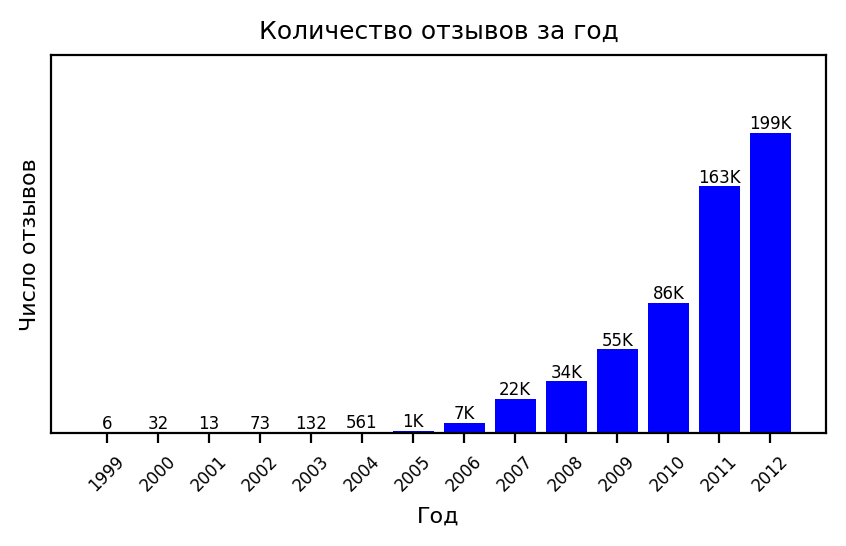

In [6]:
plt.figure(figsize=(5, 2.5), dpi=200)
plot_data = raw_df.Year.value_counts().sort_index()

# ----------------

plt.bar(plot_data.index, plot_data.values, color="blue", width=0.8)

for (xx, xy) in plot_data.iteritems():
    plt.text(xx, xy, count_label(xy), ha="center", va="bottom", fontsize=6)
    
_ = plt.xticks(plot_data.index, rotation=45, fontsize=6)
plt.tick_params(axis="y", which="both", left=False, labelleft=False)

_ = plt.ylim((0, 250000))

_ = plt.title("Количество отзывов за год", fontsize=9)
_ = plt.xlabel("Год", fontsize=8)
_ = plt.ylabel("Число отзывов", fontsize=8)

Мы наблюдаем практически экспоненциальный рост - число отзывов растёт геометрически быстро (за исключением последнего года).

К сожалению, мы знаем время только с точностью до дня, поэтому мы не можем посмотреть на распределение отзывов по времени в течение дня. Но можем проверить распределение в течение недели - наверняка в выходные у людей больше свободного времени и они могут оставить больше отзывов.

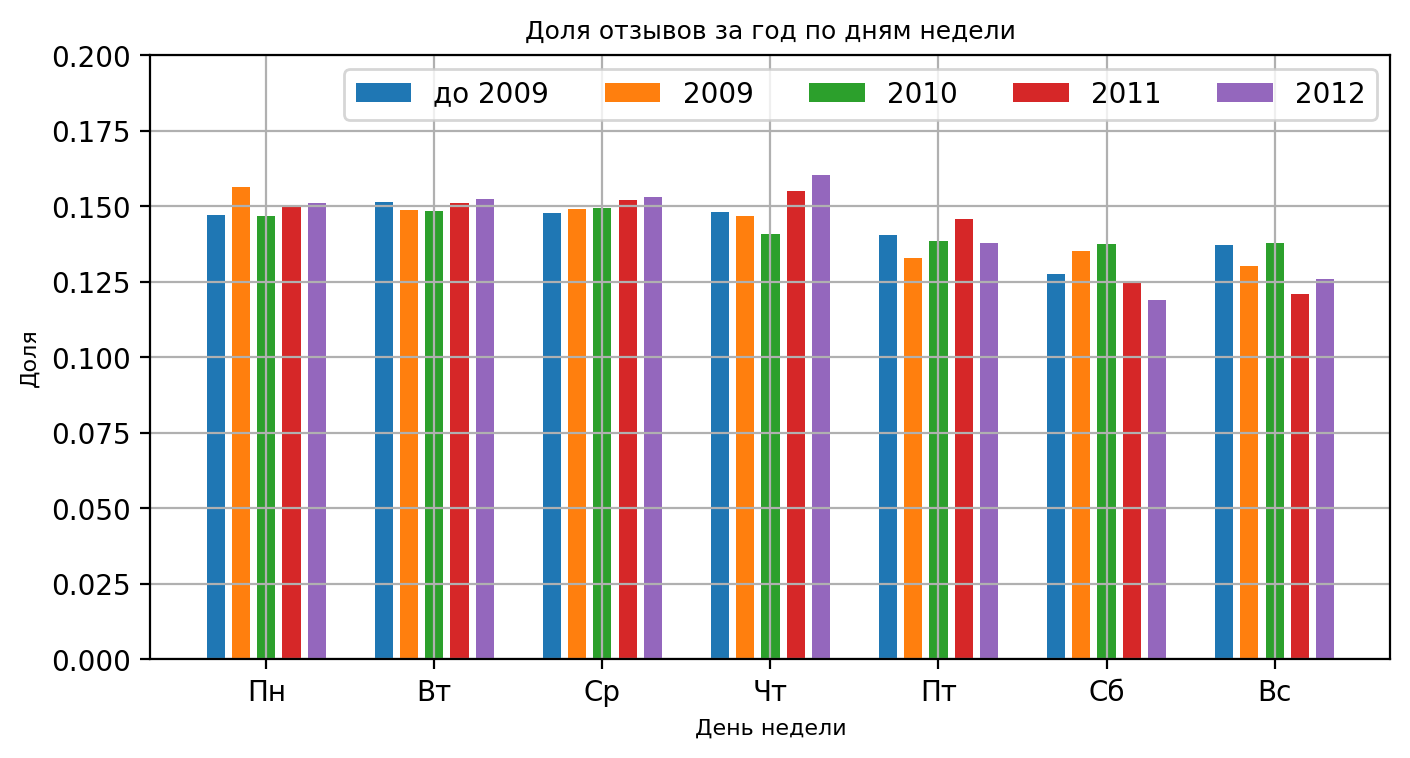

In [7]:
plt.figure(figsize=(8, 4), dpi=200)

intervals = pd.IntervalIndex.from_breaks([-np.inf, 2009, 2010, 2011, 2012, np.inf], closed="left")
labels = {x: xc for (x, xc) in zip(intervals, ("до 2009", "2009", "2010", "2011", "2012"))}

wd = 0.6

plot_data = raw_df.assign(year_bin=pd.cut(raw_df.Year, intervals)).groupby(["year_bin", "DoW"]).size()
shifts = np.linspace(-0.5 * wd, 0.5 * wd, len(intervals))
    
for (xi, xsh) in zip(intervals, shifts):
    plt.bar(
        np.arange(0, 6 + 1) + xsh,
        plot_data.loc[(xi, slice(None))].droplevel(0, axis=0).sort_index() / plot_data.loc[(xi, slice(None))].sum(),
        label=labels[xi], width=0.9 * (wd / len(intervals))         
    )
    
_ = plt.xticks(np.arange(0, 6 + 1), labels=["Пн", "Вт", "Ср", "Чт", "Пт", "Сб", "Вс"])
plt.gca().grid(True)
_ = plt.legend(ncol=5)

_ = plt.ylim((0, 0.2))
    
_ = plt.title("Доля отзывов за год по дням недели", fontsize=9)
_ = plt.xlabel("День недели", fontsize=8)
_ = plt.ylabel("Доля", fontsize=8)

Хммм... достаточно удивительно, но это не так. Напротив, ближе к концу недели доля отзывов незначительно снижается. Распределение для различных годов практически одинаковое.

## Количество отзывов

In [8]:
print(f"Different products: {raw_df.ProductId.nunique()}")
print(f"Different users: {raw_df.UserId.nunique()}")

Different products: 74258
Different users: 256059


У нас чуть меньше $75$ тысяч различных продуктов, и чуть больше $250$ тысяч различных пользователей. Посмотрим на распределение числа отзывов по продуктам, а также распределение числа отзывов по пользователям.

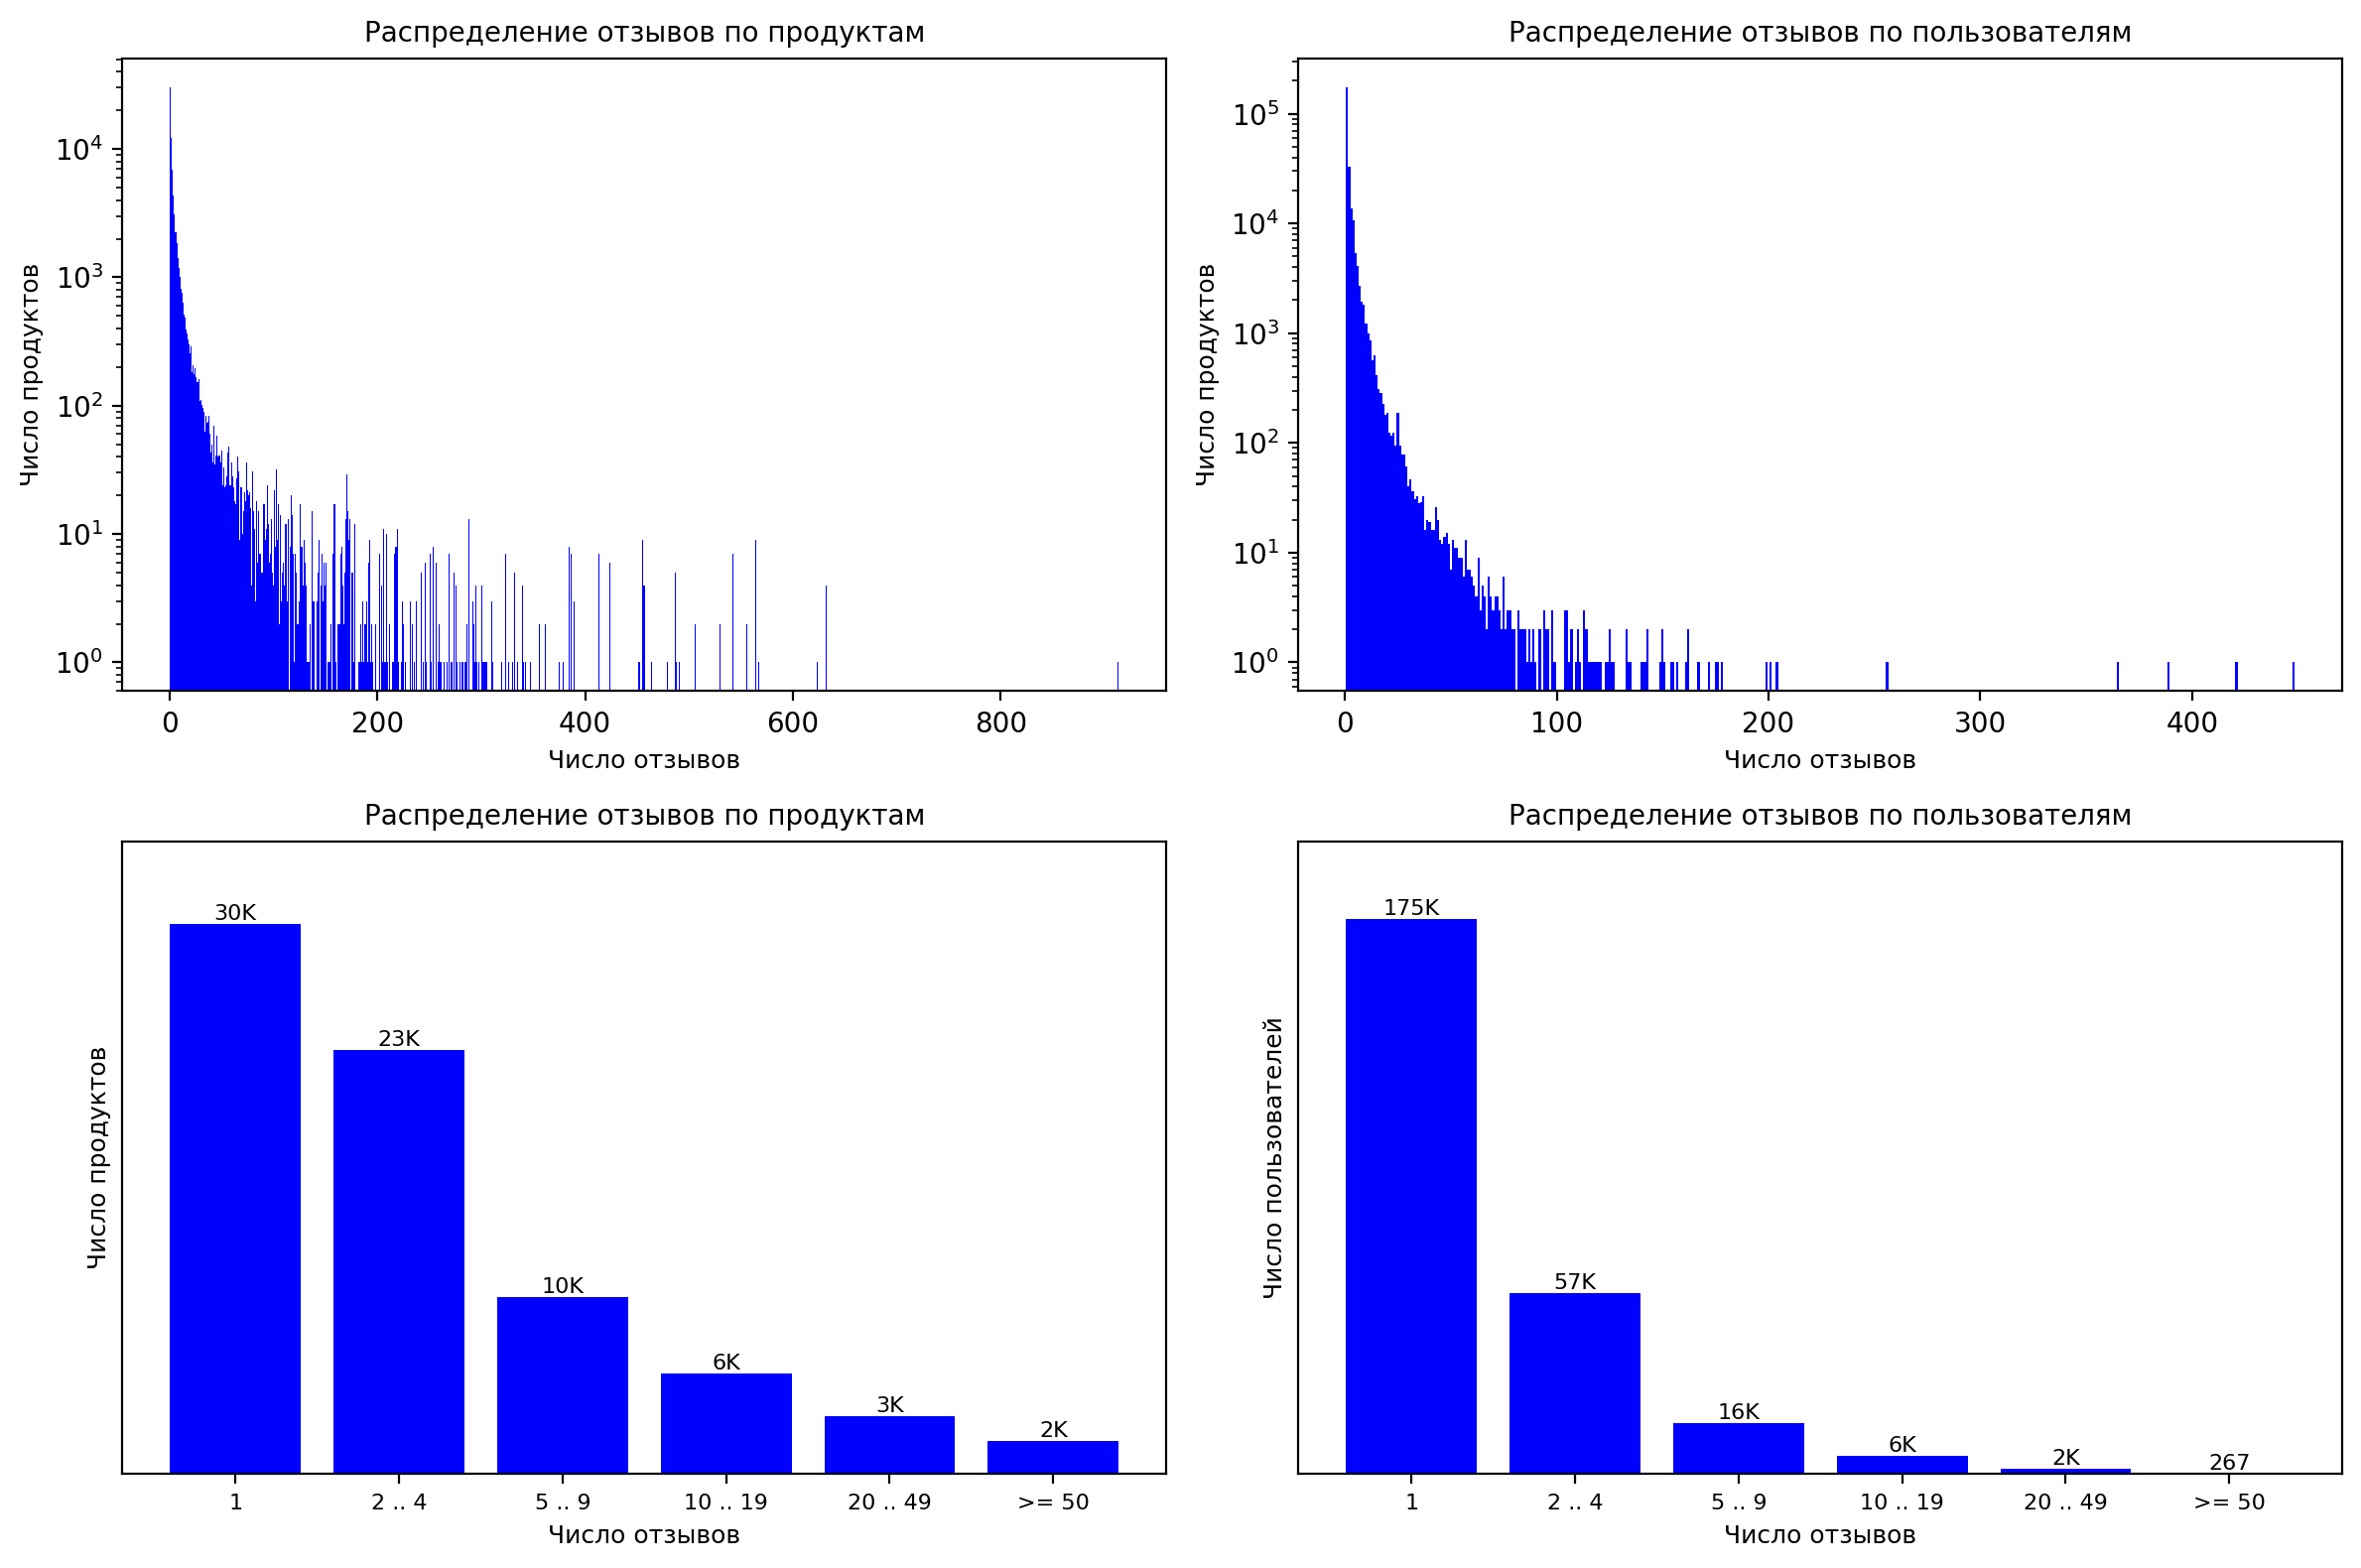

In [9]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200)

# ----------------

plt.sca(axs[0, 0])
plot_data = raw_df.groupby("ProductId").size().value_counts().sort_index()

plt.bar(plot_data.index, plot_data.values, color="blue", width=1.0)
plt.yscale("log")

_ = plt.title("Распределение отзывов по продуктам", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Число продуктов", fontsize=9)

# ----------------

plt.sca(axs[0, 1])
plot_data = raw_df.groupby("UserId").size().value_counts().sort_index()

plt.bar(plot_data.index, plot_data.values, color="blue", width=1.0)
plt.yscale("log")

_ = plt.title("Распределение отзывов по пользователям", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Число продуктов", fontsize=9)

# ----------------
# ----------------

plt.sca(axs[1, 0])

intervals = pd.IntervalIndex.from_breaks([1, 2, 5, 10, 20, 50, np.inf], closed="left")
labels = {x: xc for (x, xc) in zip(intervals, ("1", "2 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50"))}

plot_data = pd.cut(raw_df.groupby("ProductId").size(), intervals).value_counts().sort_index()
plt.bar([labels[ix] for ix in plot_data.index], plot_data.values, color="blue", width=0.8)

for (ix, (xx, xy)) in enumerate(plot_data.iteritems()):
    plt.text(ix, xy, count_label(xy), ha="center", va="bottom", fontsize=8)
    
_ = plt.title("Распределение отзывов по продуктам", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Число продуктов", fontsize=9)

_ = plt.ylim((0, 35000))

plt.gca().tick_params(axis="x", which="major", labelsize=8)
_ = plt.yticks([])

# ----------------

plt.sca(axs[1, 1])

intervals = pd.IntervalIndex.from_breaks([1, 2, 5, 10, 20, 50, np.inf], closed="left")
labels = {x: xc for (x, xc) in zip(intervals, ("1", "2 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50"))}

plot_data = pd.cut(raw_df.groupby("UserId").size(), intervals).value_counts().sort_index()
plt.bar([labels[ix] for ix in plot_data.index], plot_data.values, color="blue", width=0.8)

for (ix, (xx, xy)) in enumerate(plot_data.iteritems()):
    plt.text(ix, xy, count_label(xy), ha="center", va="bottom", fontsize=8)
    
_ = plt.title("Распределение отзывов по пользователям", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Число пользователей", fontsize=9)

_ = plt.ylim((0, 200000))

plt.gca().tick_params(axis="x", which="major", labelsize=8)
_ = plt.yticks([])

# ----------------
# ----------------

plt.tight_layout()

Распределения очень похожи - с ростом $n$ гиперэкспоненциально (т.е. логарифм уменьшается экспоненциально) падают как число продуктов, о которых оставили $n$ отзывов, так и число пользователей, оставивших $n$ отзывов. При это после определённой границы (около 100 для продуктов, меньше для пользователей) распределение уже не наблюдается вследствие недостаточной статистики - есть только отдельные экземпляры.

Посмотрим на статистику:

In [10]:
for xf in ("ProductId", "UserId"):
    data = raw_df.groupby(xf).count().values
    
    print(xf)
    print("\n".join((
        f"Mean: {np.mean(data):.2f}", 
        f"Std: {np.std(data):.2f}", 
        f"Median: {int(np.median(data))}",
        f"5% quantile: {int(np.quantile(data, 0.05))}",
        f"25% quantile: {int(np.quantile(data, 0.25))}",
        f"75% quantile: {int(np.quantile(data, 0.75))}",
        f"95% quantile: {int(np.quantile(data, 0.95))}"
    )))
    
    print()

ProductId
Mean: 7.66
Std: 26.45
Median: 2
5% quantile: 1
25% quantile: 1
75% quantile: 5
95% quantile: 26

UserId
Mean: 2.22
Std: 4.44
Median: 1
5% quantile: 1
25% quantile: 1
75% quantile: 2
95% quantile: 7



Очень большие дисперсии указывают на неравномерность распределения.

Почти $70\%$ пользователей оставили всего один отзыв. Это могут быть либо сильно возмущённые качеством продукта люди, которые зарегистрировались специально, чтобы написать об этом. Это могут быть также, например, участники акций вроде "оставь отзыв и получи скидку/подарок".

Достаточно очевидный и напрашивающийся вывод - чем лучше (или напротив, хуже) продукт - тем больше о нём отзывов. Однако количество отзывов может зависеть ещё и от того, сколько времени продукт находится на рынке. Для этого мы посчитаем "возраст" для продуктов и пользователей, как отрезок времени между первым и последним отзывом о продукте или от пользователя. Такой способ не лишён недостатков - многие объекты получат нулевой возраст, но это наилучший вариант при имеющихся данных.

In [11]:
reviews_product = raw_df.groupby("ProductId").agg({"Time": [("first", np.min), ("last", np.max)]}).droplevel(0, axis=1)
reviews_user = raw_df.groupby("UserId").agg({"Time": [("first", np.min), ("last", np.max)]}).droplevel(0, axis=1)
last_time = raw_df.Time.max()

product_lifetime = pd.merge(
    (reviews_product["last"] - reviews_product["first"]).apply(lambda x: x.days / 365.25).rename("lifetime").to_frame(),
    raw_df.groupby("ProductId").size().rename("reviews").to_frame(),
    left_index=True,
    right_index=True
)

user_lifetime = pd.merge(
    (reviews_user["last"] - reviews_user["first"]).apply(lambda x: x.days / 365.25).rename("lifetime").to_frame(),
    raw_df.groupby("UserId").size().rename("reviews").to_frame(),
    left_index=True,
    right_index=True
)

Посмотрим, как распределены "возрасты" для продуктов и пользователей.

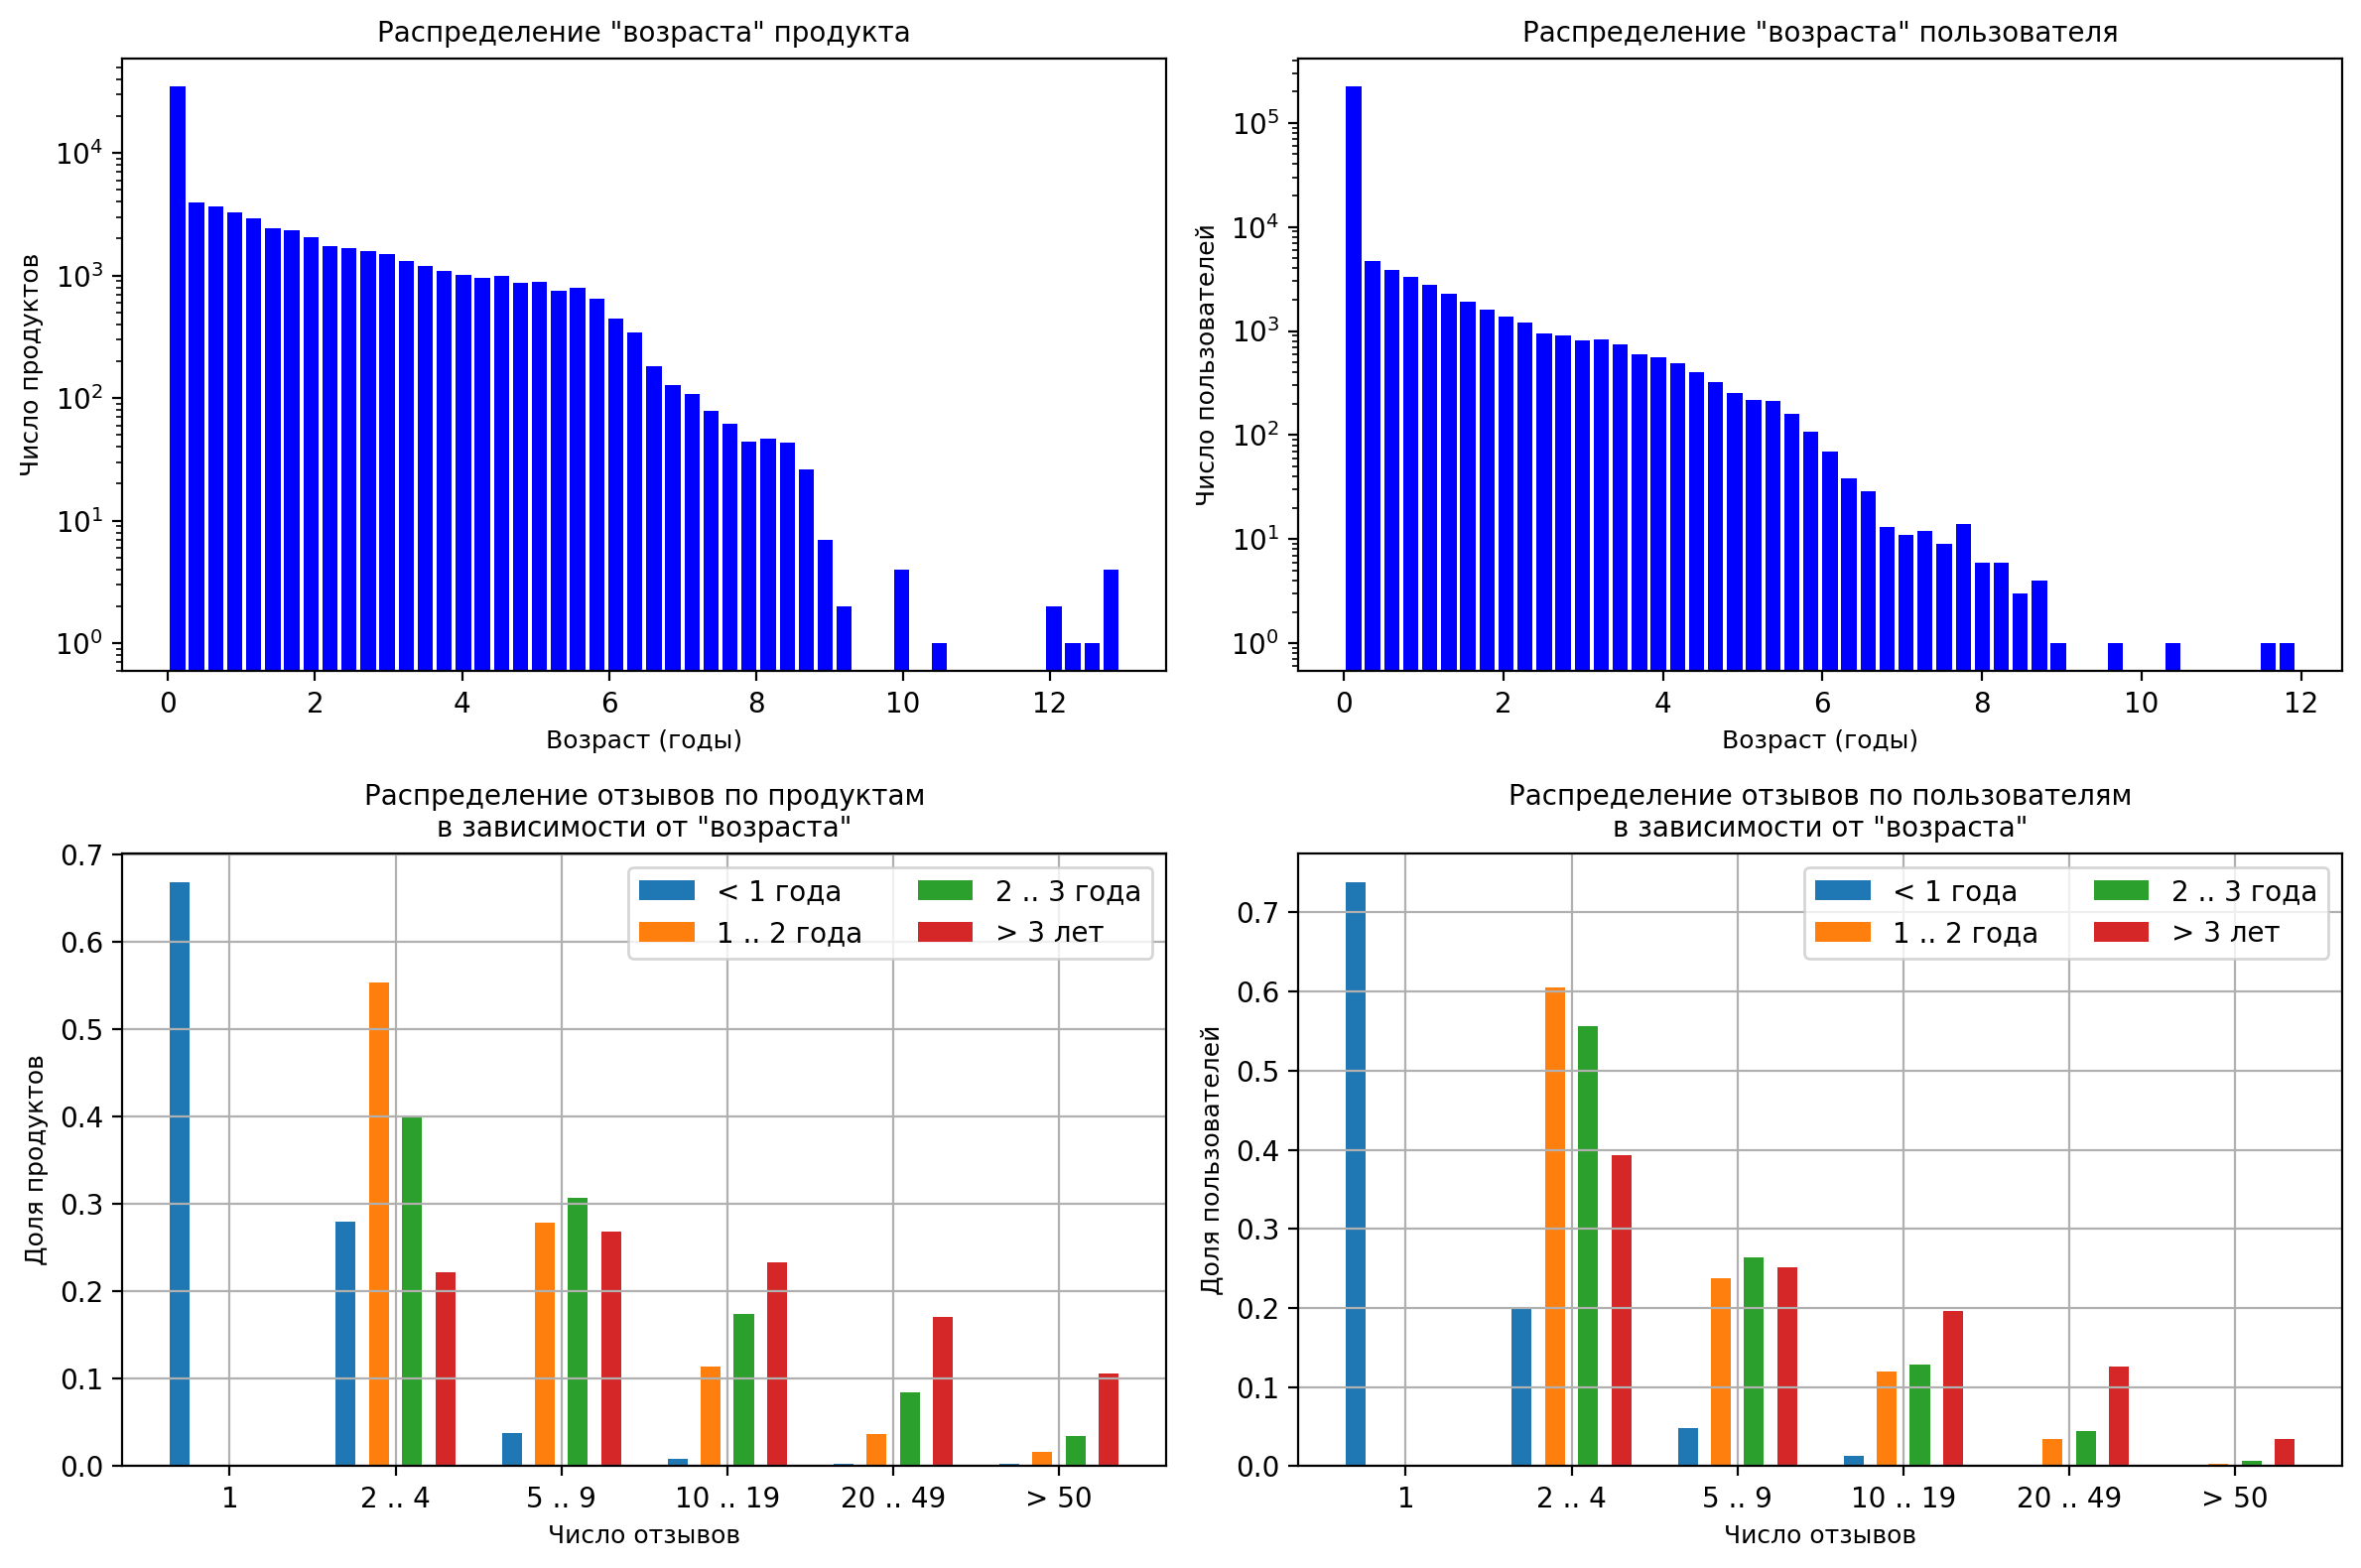

In [12]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200)

# ----------------

plt.sca(axs[0, 0])

hist = plt.hist(product_lifetime.lifetime, bins=50, color="blue", rwidth=0.8)
plt.yscale("log")

_ = plt.title("Распределение \"возраста\" продукта", fontsize=10)
_ = plt.xlabel("Возраст (годы)", fontsize=9)
_ = plt.ylabel("Число продуктов", fontsize=9)

# ----------------

plt.sca(axs[0, 1])

hist = plt.hist(user_lifetime.lifetime, bins=50, color="blue", rwidth=0.8)
plt.yscale("log")

_ = plt.title("Распределение \"возраста\" пользователя", fontsize=10)
_ = plt.xlabel("Возраст (годы)", fontsize=9)
_ = plt.ylabel("Число пользователей", fontsize=9)

# ----------------
# ----------------

plt.sca(axs[1, 0])

intervals_lt = pd.IntervalIndex.from_breaks([0.0, 1.0, 2.0, 3.0, np.inf], closed="left")
intervals_rv = pd.IntervalIndex.from_breaks([1, 2, 5, 10, 20, 50, np.inf], closed="left")
labels_lt = {x: xc for (x, xc) in zip(intervals_lt, ("< 1 года", "1 .. 2 года", "2 .. 3 года", "> 3 лет"))}
labels_rv = ("1", "2 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", "> 50")

wd = 0.6

plot_data = product_lifetime.assign(
    lti=pd.cut(product_lifetime.lifetime, intervals_lt),
    rvi=pd.cut(product_lifetime.reviews, intervals_rv)
).groupby(["lti", "rvi"]).size()

shifts = np.linspace(-0.5 * wd, 0.5 * wd, len(intervals_lt))
    
for (xi, xsh) in zip(intervals_lt, shifts):
    plt.bar(
        np.arange(0, len(intervals_rv)) + xsh,
        plot_data.loc[(xi, slice(None))].droplevel(0, axis=0).sort_index() / plot_data.loc[(xi, slice(None))].sum(),
        label=labels_lt[xi], width=0.8 * (wd / len(intervals_lt))         
    )
    
_ = plt.title("Распределение отзывов по продуктам\nв зависимости от \"возраста\"", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Доля продуктов", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals_rv)), labels=labels_rv)
plt.gca().grid(True)
_ = plt.legend(ncol=2)

# ----------------

plt.sca(axs[1, 1])

intervals_lt = pd.IntervalIndex.from_breaks([0.0, 1.0, 2.0, 3.0, np.inf], closed="left")
intervals_rv = pd.IntervalIndex.from_breaks([1, 2, 5, 10, 20, 50, np.inf], closed="left")
labels_lt = {x: xc for (x, xc) in zip(intervals_lt, ("< 1 года", "1 .. 2 года", "2 .. 3 года", "> 3 лет"))}
labels_rv = ("1", "2 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", "> 50")

wd = 0.6

plot_data = user_lifetime.assign(
    lti=pd.cut(user_lifetime.lifetime, intervals_lt),
    rvi=pd.cut(user_lifetime.reviews, intervals_rv)
).groupby(["lti", "rvi"]).size()

shifts = np.linspace(-0.5 * wd, 0.5 * wd, len(intervals_lt))
    
for (xi, xsh) in zip(intervals_lt, shifts):
    plt.bar(
        np.arange(0, len(intervals_rv)) + xsh,
        plot_data.loc[(xi, slice(None))].droplevel(0, axis=0).sort_index() / plot_data.loc[(xi, slice(None))].sum(),
        label=labels_lt[xi], width=0.8 * (wd / len(intervals_lt))         
    )
    
_ = plt.title("Распределение отзывов по пользователям\nв зависимости от \"возраста\"", fontsize=10)
_ = plt.xlabel("Число отзывов", fontsize=9)
_ = plt.ylabel("Доля пользователей", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals_rv)), labels=labels_rv)
plt.gca().grid(True)
_ = plt.legend(ncol=2)

# ----------------
# ----------------

plt.tight_layout()

Распределения очень похожи. Пики в окрестности нуля - это продукты и пользователи с одним отзывом. С ростом $x$ число продуктов/пользователей с $x$ отзывами уменьшается кусочно-линейно в логарифических координатах (т.е. падает геометрически).

На гистограммах числа отзывов с распределением по возрасту видно:
 - Около $70\%$ продуктов и пользователей с одним отзывом имеют возраст до года;
 - С увеличением возраста продукты набирают отзывы, также, как и активные пользователи оставляют больше отзывов;
 - Подавляющее большинство продуктов и почти все пользователи с более чем $50$ отзывами "старше" $3$ лет.

## Полезность отзыва и рейтинг продукта

Не все отзывы пользователей содержательны. Некоторые оставляют достаточно бессмысленные или очень короткие комментарии типа "Не понравилось". Поэтому остальные пользователи оценивают, насколько полезным был каждый отзыв. Это выражается двумя числами: `HelpfulnessDenominator` и `HelpfulnessNumerator` - соответственно, общее число оценок и число оценок "Полезный".

Мы введём дополнительную величину - "среднюю полезность", долю хороших оценок (будем считать её нулевой, если у отзыва нет оценок).

In [13]:
raw_df.rename({"HelpfulnessDenominator": "HD", "HelpfulnessNumerator": "HN"}, axis=1, inplace=True)
raw_df.loc[:, "HS"] = (raw_df.HN / raw_df.HD).fillna(0.0)
raw_df[["HD", "HN", "HS"]].describe()

,HD,HN,HS
count,568454.00000,568454.000000,568454.000000
mean,2.22881,1.743817,0.407862
std,8.28974,7.636513,0.462068
min,0.00000,0.000000,0.000000
25%,0.00000,0.000000,0.000000
50%,1.00000,0.000000,0.000000
75%,2.00000,2.000000,1.000000
max,923.00000,866.000000,3.000000


Итак, мы видим, что в среднем каждый отзыв получает чуть больше двух оценок полезности, а средняя полезность меньше $0.5$ (хотя это, вероятнее всего, некорректно, поскольку мы назначили $0$ всем отзывам без оценок).

И кажется, у нас есть отзывы со средней полезностью больше $1$!

In [14]:
flag = (raw_df.HN > raw_df.HD).values
raw_df[flag]

,Id,ProductId,UserId,ProfileName,HN,HD,Score,Time,Summary,Text,Year,Month,Day,DoW,HS
44736,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,2008-06-08,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...,2008,6,8,6,1.5
64421,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,2008-10-25,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...,2008,10,25,5,3.0


Вероятно, это сбой в системе сбора отзывов - больше пользователей определили эти отзывы как полезные, чем всего проголосовало. Поскольку это всего две строки - мы можем спокойно от них избавиться.

In [15]:
raw_df = raw_df[~flag]
raw_df.shape

(568452, 15)

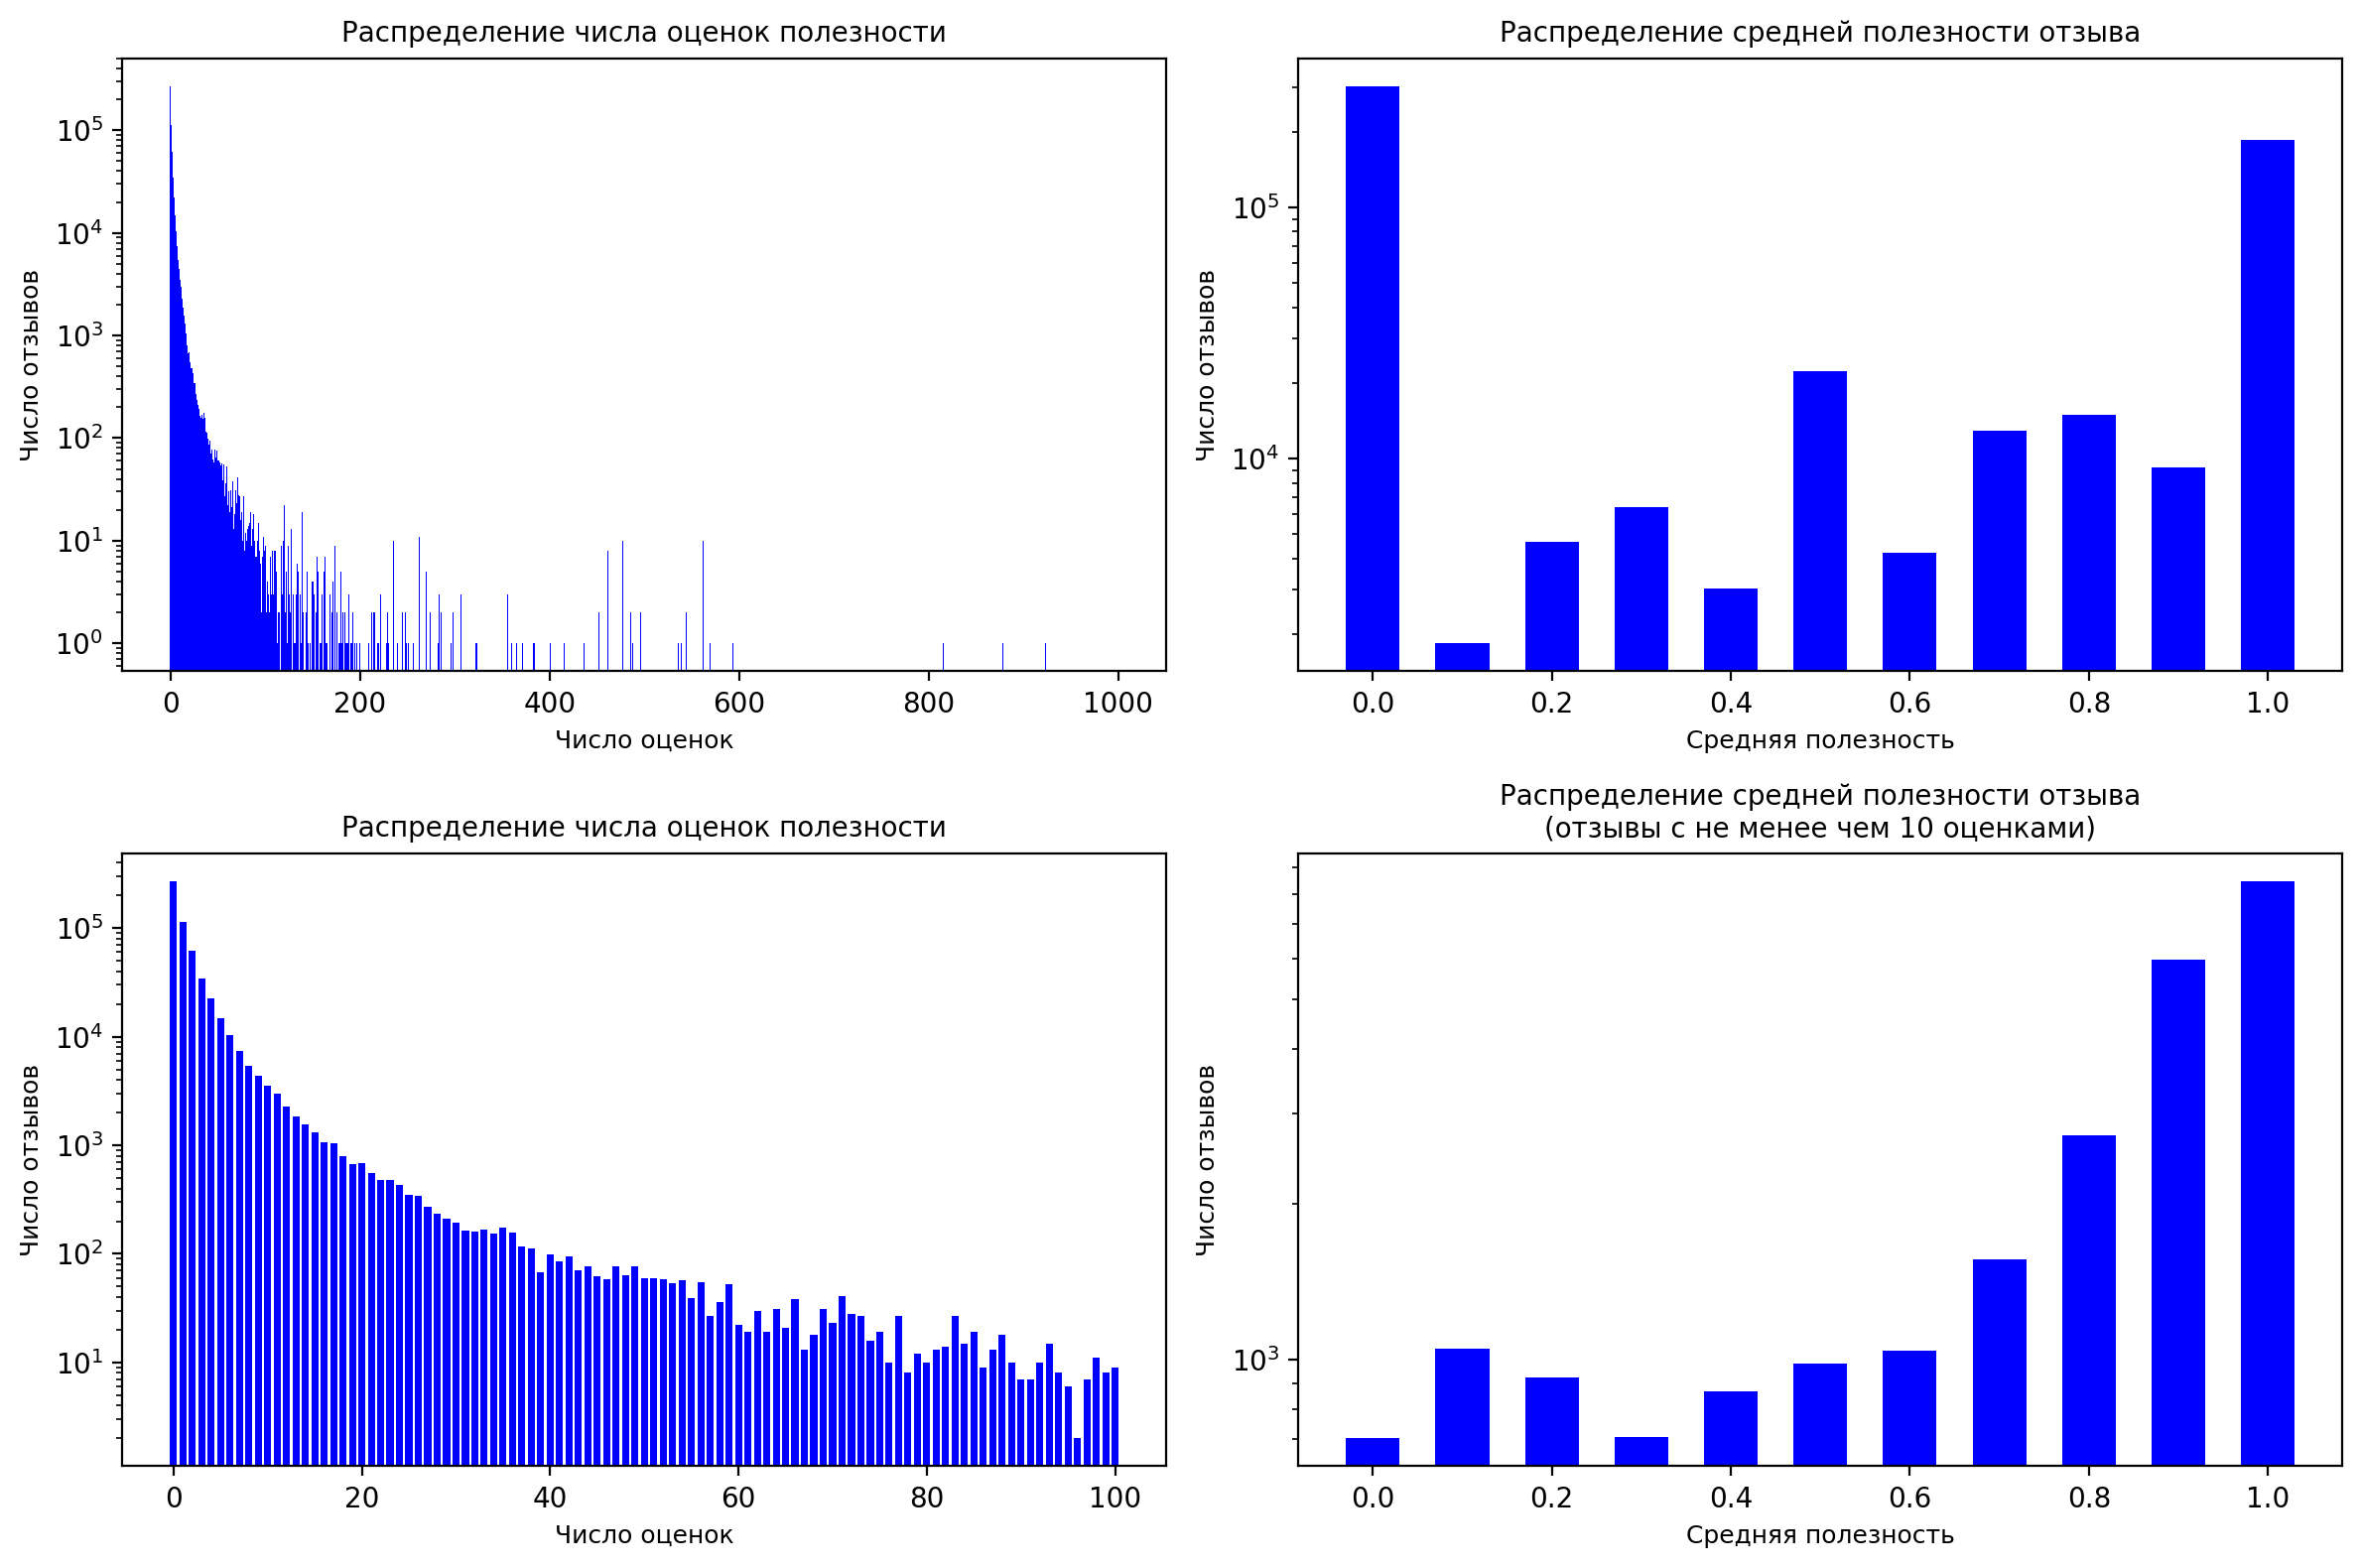

In [16]:
fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(12, 8), dpi=200)

# ----------------

plt.sca(axs[0, 0])

plt.hist(raw_df.HD, bins=np.arange(-0.5, 1000.0 + 0.5 + 1e-3, 1.0), rwidth=1.0, color="blue")
plt.yscale("log")

plt.title("Распределение числа оценок полезности", fontsize=10)
plt.xlabel("Число оценок", fontsize=9)
plt.ylabel("Число отзывов", fontsize=9)

# ----------------

plt.sca(axs[1, 0])

plt.hist(raw_df.HD, bins=np.arange(-0.5, 100.0 + 0.5 + 1e-3, 1.0), rwidth=0.75, color="blue")
plt.yscale("log")

plt.title("Распределение числа оценок полезности", fontsize=10)
plt.xlabel("Число оценок", fontsize=9)
plt.ylabel("Число отзывов", fontsize=9)

# ----------------
# ----------------

plt.sca(axs[0, 1])

plt.hist(raw_df.HS, bins=np.arange(-0.05, 1.00 + 0.05 + 1e-3, 0.1), rwidth=0.6, color="blue")
plt.yscale("log")

plt.title("Распределение средней полезности отзыва", fontsize=10)
plt.xlabel("Средняя полезность", fontsize=9)
plt.ylabel("Число отзывов", fontsize=9)

# ----------------

plt.sca(axs[1, 1])

plt.hist(raw_df.loc[raw_df.HD >= 10, "HS"], bins=np.arange(-0.05, 1.00 + 0.05 + 1e-3, 0.1), rwidth=0.6, color="blue")
plt.yscale("log")

plt.title("Распределение средней полезности отзыва\n(отзывы с не менее чем 10 оценками)", fontsize=10)
plt.xlabel("Средняя полезность", fontsize=9)
plt.ylabel("Число отзывов", fontsize=9)

# ----------------

plt.tight_layout()

Мы видим, что значительная часть отзывов получает всего несколько оценок полезности (число отзывов с $n$ оценками падает гиперэкспоненциально от $n$). Среди отзывов с более чем $100$ оценками уже не удаётся изобразить распределение из-за их малого числа.

Средняя полезность имеет моды $0$ и $1$ (т.е. либо все оценки отрицательные, либо все положительные). Необходимо отметить, что в условиях малого среднего числа оценок распределение средней полезности нерепрезентативно (поскольку считается как $n / m$, где $m$ принимает ограниченный набор значений, поэтому некоторые бины будут переполнены, а в некоторые попадёт существенно меньше значений).

С другой стороны, если мы отфильтруем отзывы с достаточно большим числом оценок (не меньше $10$), то мы видим качественное изменение распределения. Такие отзывы существенно чаще определяются, как полезные.

Главная характеристика отзыва - это рейтинг (`Score`) от $1$ (очень плохо) до $5$ (отлично). В отличие от оценки полезности рейтинг присутствует всегда. Посмотрим на его распределение.

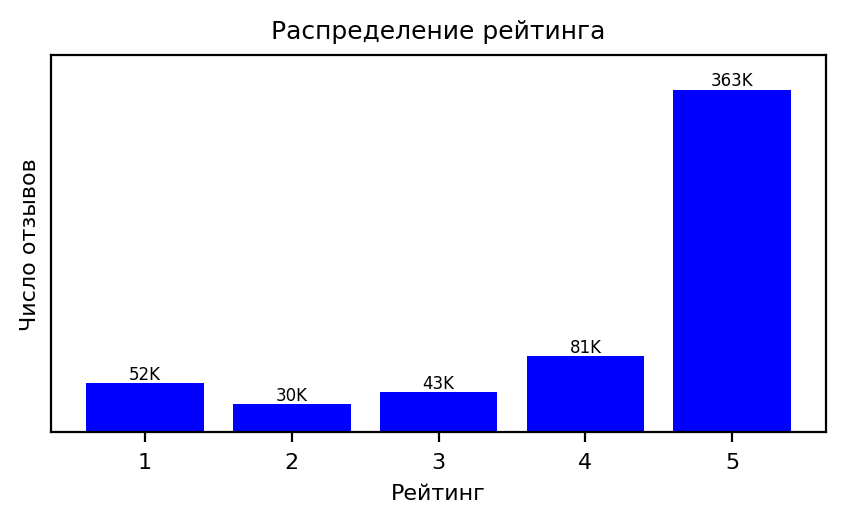

In [17]:
plt.figure(figsize=(5, 2.5), dpi=200)
plot_data = raw_df.Score.value_counts().sort_index()

# ----------------

plt.bar(plot_data.index, plot_data.values, color="blue", width=0.8)

for (xx, xy) in plot_data.iteritems():
    plt.text(xx, xy, count_label(xy), ha="center", va="bottom", fontsize=6)
    
_ = plt.xticks(plot_data.index, fontsize=8)
plt.tick_params(axis="y", which="both", left=False, labelleft=False)

_ = plt.ylim((0, 400000))

_ = plt.title("Распределение рейтинга", fontsize=9)
_ = plt.xlabel("Рейтинг", fontsize=8)
_ = plt.ylabel("Число отзывов", fontsize=8)

Мы видим сильную склонность людей к переоценке продуктов. Заметна также вторая мода - $1$. Отсюда можем сделать вывод, что люди склонны писать отзыв на продукты "экстремального" качества (т.е. либо очень хорошие, либо очень плохие), в то время как продукты среднего качества остаются с меньшим числом оценок.

При этом отзывов с $5$ существенно больше, чем в $1$. Возможно, так происходит из-за нежелания писать плохой отзыв, даже если продукт не понравился - проще просто им не пользоваться больше.

Проверим теперь, как коррелируют оценки полезности с рейтингом.

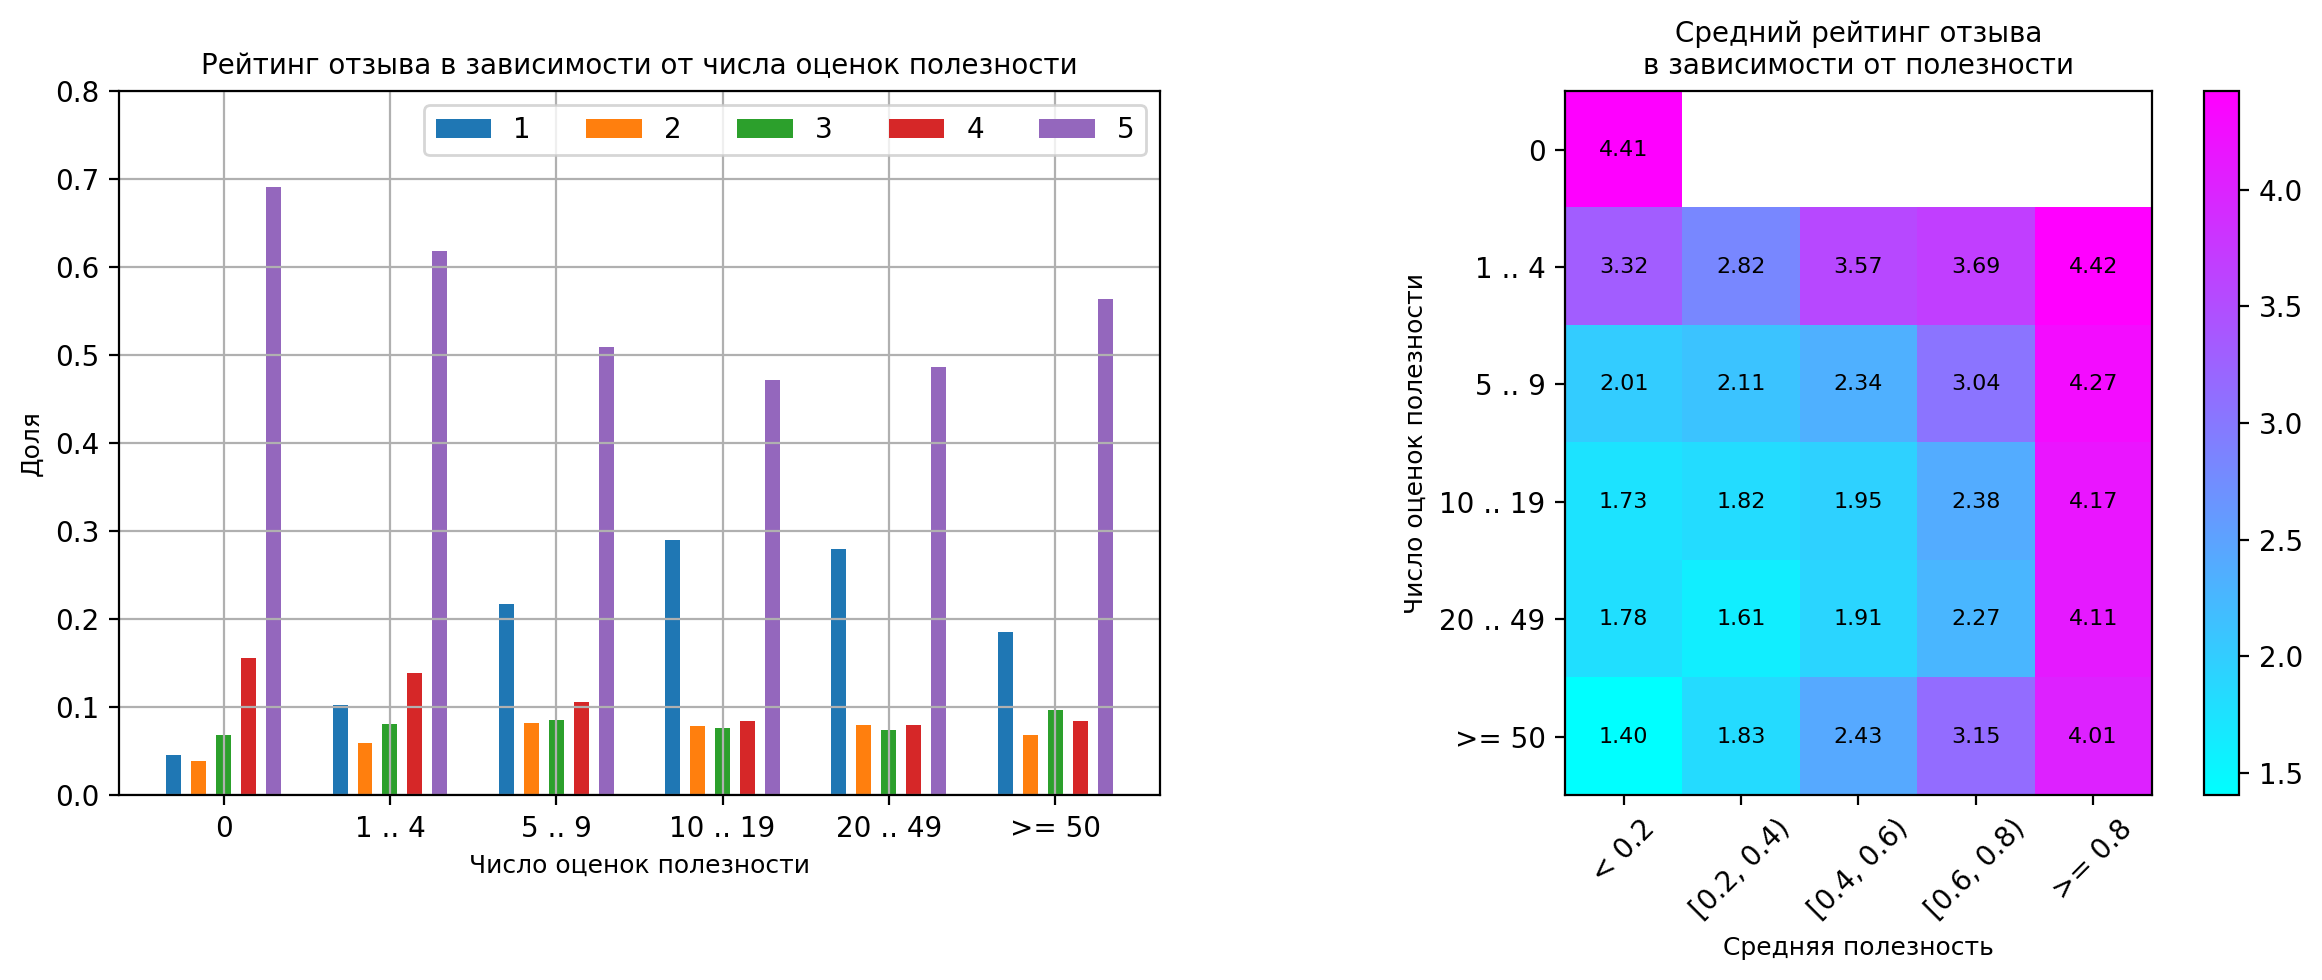

In [18]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), dpi=200)

# ----------------

plt.sca(axs[0])

intervals = pd.IntervalIndex.from_breaks([0, 1, 5, 10, 20, 50, np.inf], closed="left")
labels = ("0", "1 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50")

wd = 0.6

plot_data = raw_df.assign(HD_group=pd.cut(raw_df.HD, intervals)).groupby(["Score", "HD_group"]).size()
shifts = np.linspace(-0.5 * wd, 0.5 * wd, 5)
    
for (xs, xsh) in zip(range(1, 5 + 1), shifts):
    plt.bar(
        np.arange(len(intervals)) + xsh,
        plot_data.loc[(xs, slice(None))].droplevel(0, axis=0).sort_index() / plot_data.groupby("HD_group").sum().sort_index(),
        label=f"{xs}", width=0.9 * (wd / len(intervals))         
    )
    
_ = plt.title("Рейтинг отзыва в зависимости от числа оценок полезности", fontsize=10)
_ = plt.xlabel("Число оценок полезности", fontsize=9)
_ = plt.ylabel("Доля", fontsize=9)

_ = plt.ylim((0.0, 0.8))
    
_ = plt.xticks(np.arange(0, len(intervals)), labels=labels)
plt.gca().grid(True)
_ = plt.legend(ncol=5)

# ----------------

plt.sca(axs[1])

intervals_hd = pd.IntervalIndex.from_breaks([0, 1, 5, 10, 20, 50, np.inf], closed="left")
intervals_hs = pd.IntervalIndex.from_breaks([0.0, 0.2, 0.4, 0.6, 0.8, np.inf], closed="left")
labels_hd = ("0", "1 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50")
labels_hs = ("< 0.2", "[0.2, 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", ">= 0.8")

plot_data = raw_df.assign(HD_group=pd.cut(raw_df.HD, intervals_hd), HS_group=pd.cut(raw_df.HS, intervals_hs)).\
    groupby(["HD_group", "HS_group"]).agg({"Score": "mean"}).values.reshape((len(intervals_hd), len(intervals_hs)))

plt.imshow(plot_data, cmap="cool")

itr = np.nditer(plot_data, flags=["multi_index"])

for x in itr:
    idx = itr.multi_index
    plt.text(idx[1], idx[0], f"{x:.2f}" if not np.isnan(x) else "", ha="center", va="center", fontsize=8)
    
_ = plt.title("Средний рейтинг отзыва\nв зависимости от полезности", fontsize=10)
_ = plt.xlabel("Средняя полезность", fontsize=9)
_ = plt.ylabel("Число оценок полезности", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals_hs)), labels=labels_hs, rotation=45)
_ = plt.yticks(np.arange(0, len(intervals_hd)), labels=labels_hd)

plt.colorbar()

# ----------------

plt.tight_layout()

Интересная зависимость. Мы видим явный минимум высоких оценок - это отзывы, полезность которых оценили от $10$ до $19$ человек. В этой же окрестности лежит максимум низких оценок. Распределение нейтральных оценок почти постоянно. Получается, что "недооценённые" и "переоценённые" отзывы скорее сильно положительные, а находящиеся в середине спектра - имеют большую долю сильно отрицательных.

На диаграмме справа можно наблюдать, как связаны число оценок полезности, полезность и рейтинг отзыва.

По соглашению все отзывы без оценок имеют полезность $0$. Эти отзывы в основном сильно положительны. Вероятно, это короткие сообщения типа "понравилось", "классно" и тому подобные.

Для остальных отзывов с хотя бы одной оценкой мы наблюдаем что-то вроде зависимости "из левого нижнего угла в правый верхний". Если средняя полезность - низкая, то чем больше оценок, тем в среднем отзыв негативнее. При средних показателях полезности наблюдаем тот же минимум посередине, что и на гистограммах. Наконец, сильно полезные отзывы в своей массе положительны, и имеется обратная зависимость от числа оценок.

Проверим также, меняется ли динамика оценки продуктов и отзывов в зависимости от их "возраста".

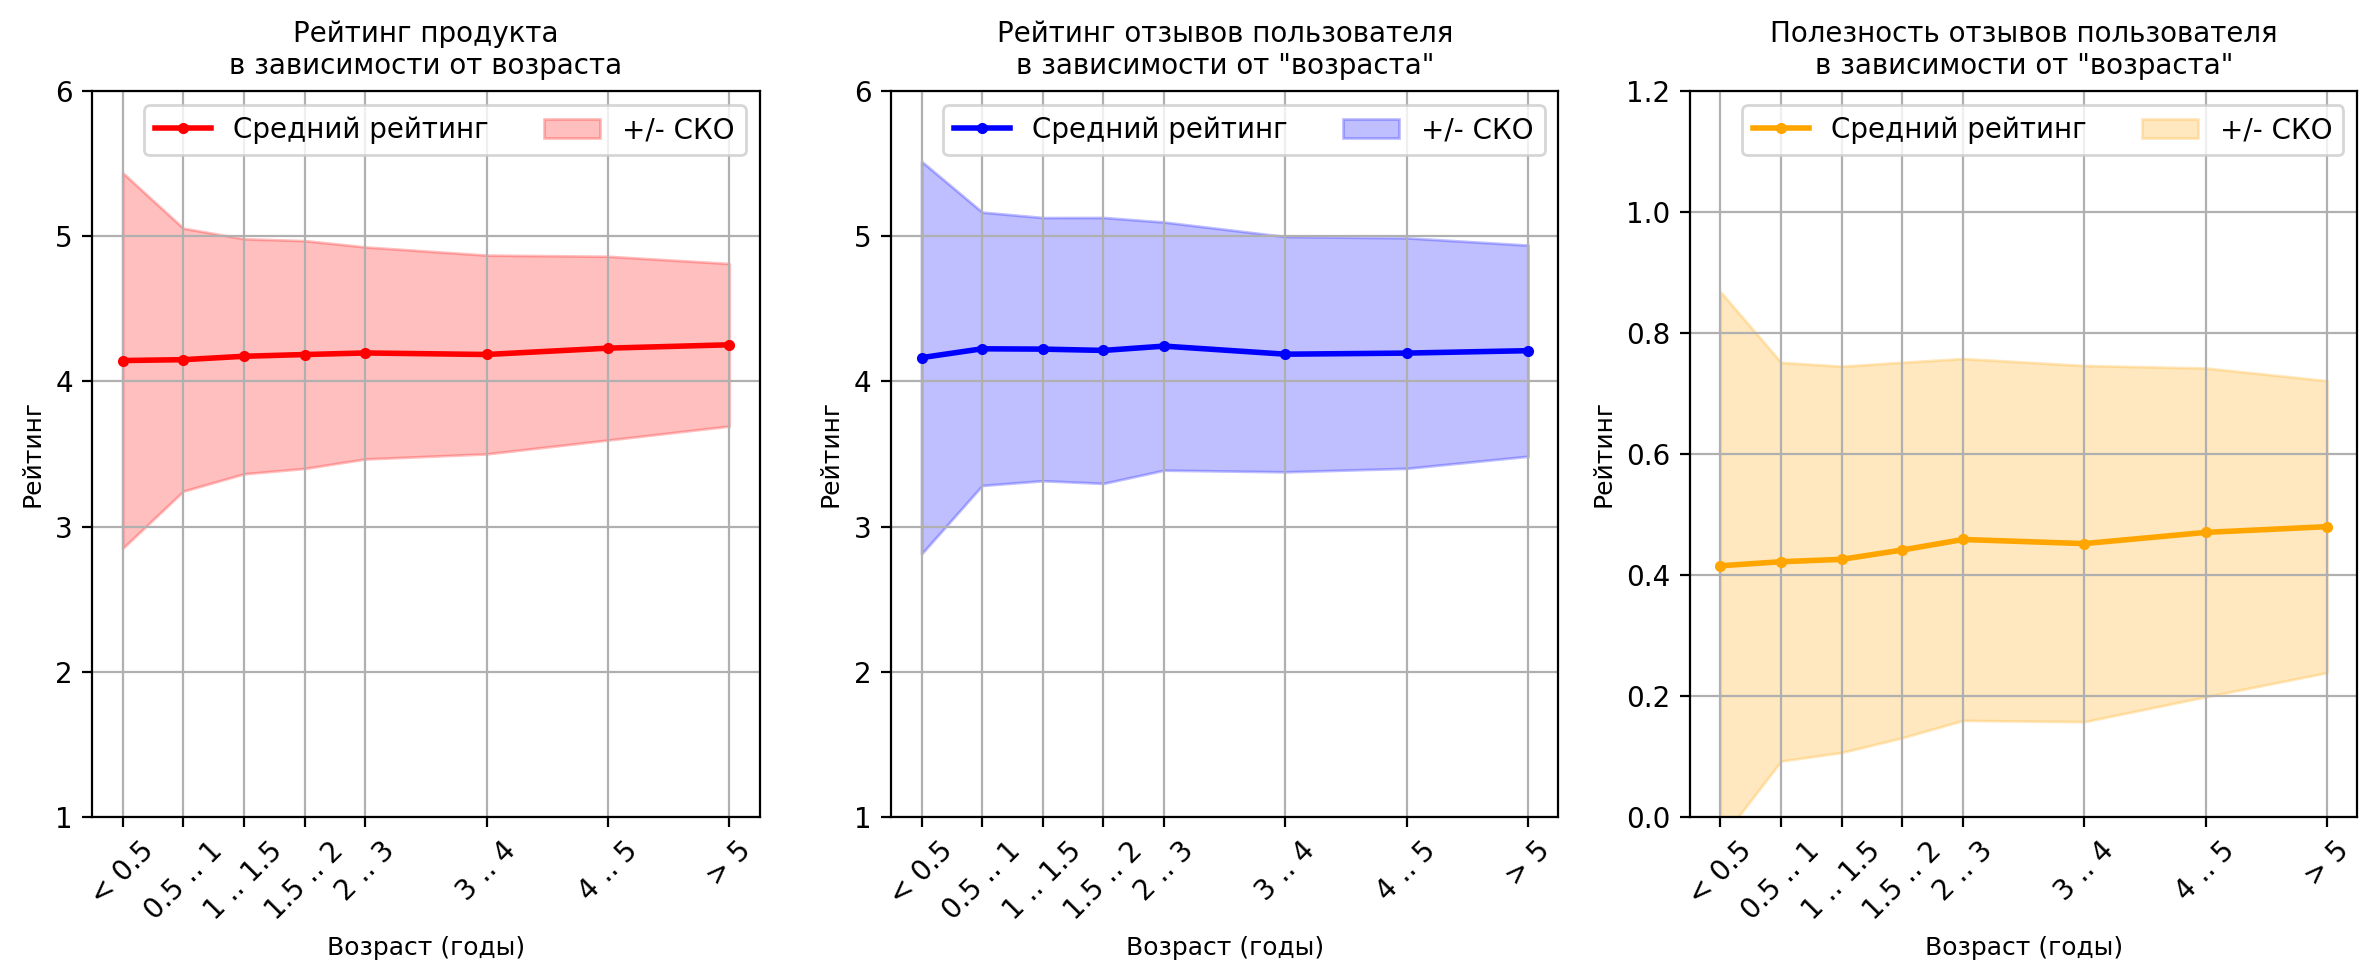

In [19]:
fig, axs = plt.subplots(ncols=3, nrows=1, figsize=(12, 5), dpi=200)

# ----------------

plt.sca(axs[0])

plot_data = raw_df.groupby("ProductId").agg({
    "Time": [("lifetime", lambda x: np.max(x) - np.min(x))],
    "Score": [("mean_score", np.mean)],
}).droplevel(0, axis=1)

lt_breaks = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, np.inf]
labels = ["< 0.5", "0.5 .. 1", "1 .. 1.5", "1.5 .. 2", "2 .. 3", "3 .. 4", "4 .. 5", "> 5"]

intervals = pd.IntervalIndex.from_breaks([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, np.inf], closed="left")
plot_data.loc[:, "lifetime_int"] = pd.cut(
    plot_data.lifetime.apply(lambda x: x.days / 365.25),
    intervals
)

plot_data = plot_data.groupby("lifetime_int").agg({
    "mean_score": [("mean", np.mean), ("std", np.std)]
}).droplevel(0, axis=1)

plt.plot(lt_breaks[:-1], plot_data["mean"], color="red", linewidth=2, marker=".", label="Средний рейтинг")
plt.fill_between(
    lt_breaks[:-1], plot_data["mean"] + plot_data["std"], plot_data["mean"] - plot_data["std"], 
    color="red", linewidth=1, alpha=0.25, label="+/- СКО"
)
    
_ = plt.title("Рейтинг продукта\nв зависимости от возраста", fontsize=10)
_ = plt.xlabel("Возраст (годы)", fontsize=9)
_ = plt.ylabel("Рейтинг", fontsize=9)

plt.ylim((1.0, 6.0))
    
_ = plt.xticks(lt_breaks[:-1], labels=labels, rotation=45)
plt.gca().grid(True)
_ = plt.legend(ncol=2)

# ----------------
# ----------------

plot_data = raw_df.groupby("UserId").agg({
    "Time": [("lifetime", lambda x: np.max(x) - np.min(x))],
    "Score": [("mean_score", np.mean)],
    "HS": [("mean_hs", np.mean)],
}).droplevel(0, axis=1)

lt_breaks = [0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, np.inf]
labels = ["< 0.5", "0.5 .. 1", "1 .. 1.5", "1.5 .. 2", "2 .. 3", "3 .. 4", "4 .. 5", "> 5"]

intervals = pd.IntervalIndex.from_breaks([0.0, 0.5, 1.0, 1.5, 2.0, 3.0, 4.0, 5.0, np.inf], closed="left")
plot_data.loc[:, "lifetime_int"] = pd.cut(
    plot_data.lifetime.apply(lambda x: x.days / 365.25),
    intervals
)

plot_data = plot_data.groupby("lifetime_int").agg({
    "mean_score": [("mean_score", np.mean), ("std_score", np.std)],
    "mean_hs": [("mean_hs", np.mean), ("std_hs", np.std)]
}).droplevel(0, axis=1)

# ----------------

plt.sca(axs[1])

plt.plot(lt_breaks[:-1], plot_data["mean_score"], color="blue", linewidth=2, marker=".", label="Средний рейтинг")
plt.fill_between(
    lt_breaks[:-1], plot_data["mean_score"] + plot_data["std_score"], plot_data["mean_score"] - plot_data["std_score"], 
    color="blue", linewidth=1, alpha=0.25, label="+/- СКО"
)
    
_ = plt.title("Рейтинг отзывов пользователя\nв зависимости от \"возраста\"", fontsize=10)
_ = plt.xlabel("Возраст (годы)", fontsize=9)
_ = plt.ylabel("Рейтинг", fontsize=9)

plt.ylim((1.0, 6.0))
    
_ = plt.xticks(lt_breaks[:-1], labels=labels, rotation=45)
plt.gca().grid(True)
_ = plt.legend(ncol=2)

# ----------------

plt.sca(axs[2])

plt.plot(lt_breaks[:-1], plot_data["mean_hs"], color="orange", linewidth=2, marker=".", label="Средний рейтинг")
plt.fill_between(
    lt_breaks[:-1], plot_data["mean_hs"] + plot_data["std_hs"], plot_data["mean_hs"] - plot_data["std_hs"], 
    color="orange", linewidth=1, alpha=0.25, label="+/- СКО"
)
    
_ = plt.title("Полезность отзывов пользователя\nв зависимости от \"возраста\"", fontsize=10)
_ = plt.xlabel("Возраст (годы)", fontsize=9)
_ = plt.ylabel("Рейтинг", fontsize=9)

plt.ylim((0.0, 1.2))
    
_ = plt.xticks(lt_breaks[:-1], labels=labels, rotation=45)
plt.gca().grid(True)
_ = plt.legend(ncol=2)

# ----------------
# ----------------

plt.tight_layout()

Удивительно, но зависимости средних значений от возраста практически отсутствуют. Можно было бы предположить, что чем дольше продукт на рынке - тем он должен быть лучше. Можно заметить слабую зависимость полезности отзывов от "возраста" пользователя - т.е. чем он больше времени провел на сайте, тем в среднем его отзывы чуть более полезны.

Во всех случаях, однако, мы можем наблюдать снижение дисперсии. А значит, даже если среднее меняется слабо - "взрослые" продукты и пользователи существенно сильнее сконцентрированы вокруг своих средних, в то время как среди "молодых" есть множество выбросов.

## Текст

Рассмотрим теперь, наверное, наиболее значительную часть датасета - тексты отзывов. Для работы с текстами будем использовать библиотеку `nltk`.

### Анализ длины предложений

Разобъём каждый отзыв на предложения. Предварительно удалим все `html`-тэги, а также расставим необходимые пробелы между знаками препинания в конце предложений (иначе мы можем запутать `sent_tokenizer`).

In [20]:
%%time

re_dot = re.compile("([.?!])([A-Za-z0-9])")
raw_df["Text_Sentences"] = raw_df.Text.apply(
    lambda x: sent_tokenize(re_dot.sub(r"\1 \2", BeautifulSoup(x, "lxml").text))
)

CPU times: user 3min 22s, sys: 1.12 s, total: 3min 23s
Wall time: 3min 23s


Проверим следующее предположение: чем больше в отзыве предложений, тем больше людей сочтут его полезным и не поленятся поставить оценку.

In [21]:
raw_df["nSentences"] = raw_df.Text_Sentences.apply(len)
raw_df.nSentences.describe()

count    568452.000000
mean          5.613392
std           4.588696
min           1.000000
25%           3.000000
50%           4.000000
75%           7.000000
max         382.000000
Name: nSentences, dtype: float64

Средняя длина отзыва - $5.6$ предложений, при этом половина отзывов не длиннее $4$-х, и только четверть не короче $7$. Построим распределения.

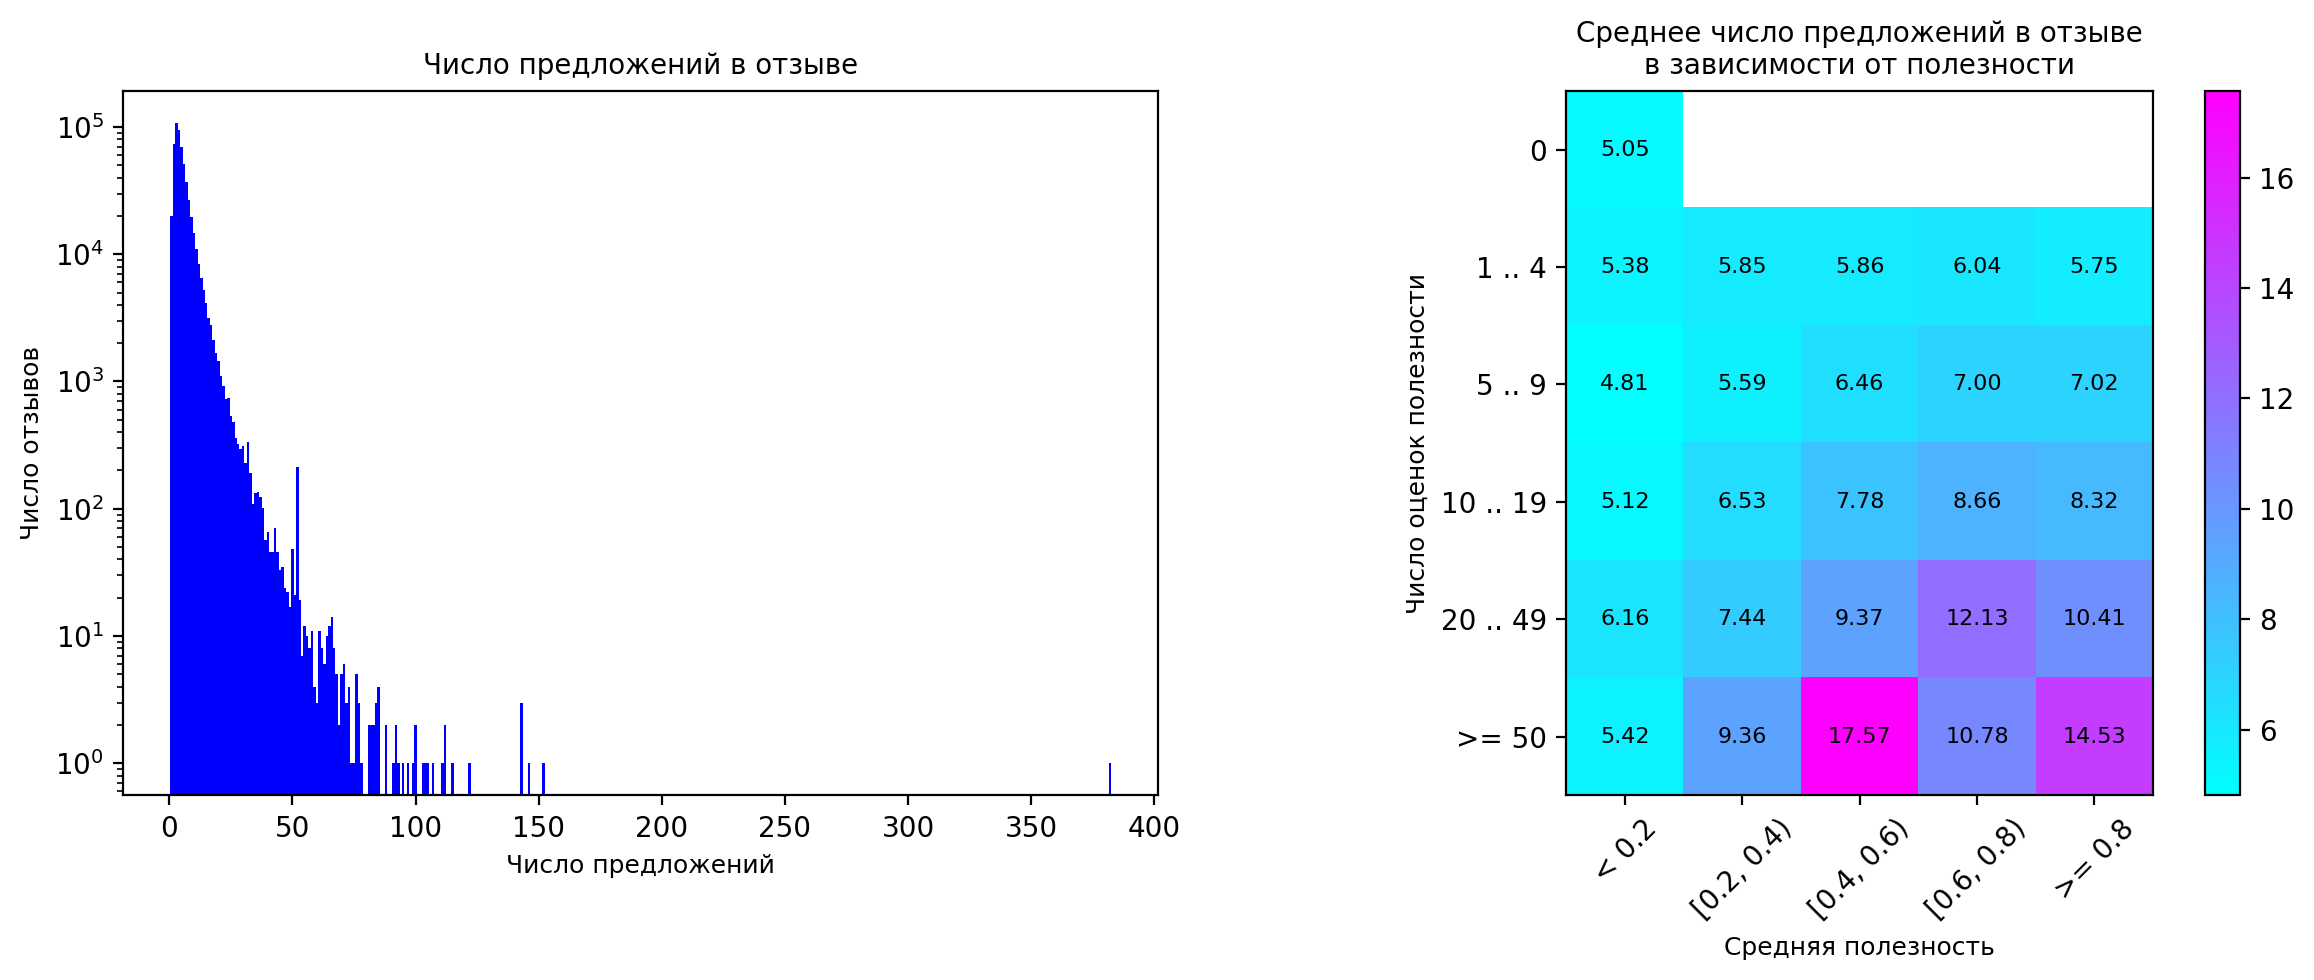

In [22]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), dpi=200)

# ----------------

plt.sca(axs[0])

plot_data = raw_df.groupby("nSentences").size().sort_index()
plt.bar(plot_data.index, plot_data.values, width=1.0, color="blue")
plt.yscale("log")

plt.title("Число предложений в отзыве", fontsize=10)
plt.xlabel("Число предложений", fontsize=9)
plt.ylabel("Число отзывов", fontsize=9)

# ----------------

plt.sca(axs[1])

intervals_hd = pd.IntervalIndex.from_breaks([0, 1, 5, 10, 20, 50, np.inf], closed="left")
intervals_hs = pd.IntervalIndex.from_breaks([0.0, 0.2, 0.4, 0.6, 0.8, np.inf], closed="left")
labels_hd = ("0", "1 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50")
labels_hs = ("< 0.2", "[0.2, 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", ">= 0.8")

plot_data = raw_df.assign(HD_group=pd.cut(raw_df.HD, intervals_hd), HS_group=pd.cut(raw_df.HS, intervals_hs)).\
    groupby(["HD_group", "HS_group"]).agg({"nSentences": "mean"}).values.reshape((len(intervals_hd), len(intervals_hs)))

plt.imshow(plot_data, cmap="cool")

itr = np.nditer(plot_data, flags=["multi_index"])

for x in itr:
    idx = itr.multi_index
    plt.text(idx[1], idx[0], f"{x:.2f}" if not np.isnan(x) else "", ha="center", va="center", fontsize=8)
    
_ = plt.title("Среднее число предложений в отзыве\nв зависимости от полезности", fontsize=10)
_ = plt.xlabel("Средняя полезность", fontsize=9)
_ = plt.ylabel("Число оценок полезности", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals_hs)), labels=labels_hs, rotation=45)
_ = plt.yticks(np.arange(0, len(intervals_hd)), labels=labels_hd)

plt.colorbar()

# ----------------

plt.tight_layout()

Мы видим, что доля длинных отзывов очень невелика - распределение достигает моды где-то в окрестности $5$ предложений на отзыв, после чего гиперэкспоненциально падает (есть какой-то выдающийся отзыв на почти $400$ предложений!).

На диаграмме справа мы видим подтверждение нашего предположения: короткие отзывы получают небольшое число оценок (правда, распределение их полезности близко к равномерному), а чем больше у отзыва оценок - тем в среднем он длиннее.

Среди отзывов с большим числом оценок:
 - короткие отзывы, как правило, бесполезные;
 - есть странный пик в окрестности полезности $0.5$;
 - чем длиннее отзыв, тем он полезнее.

### Анализ количества слов

Разделим отзывы на слова. Все слова приведём к нижнему регистру и удалим все цифры, знаки препинания, смайлики и т.д.

In [23]:
re_word = re.compile("[A-Za-z]+")

text_words = [
    [
        y.lower() for y in word_tokenize(re_dot.sub(r"\1 \2", BeautifulSoup(x, "lxml").text))
        if re_word.fullmatch(y)
    ]
    for x in tqdm(raw_df.Text)
]

Теперь удалим все стоп-слова, и проведём лемматизацию - приведём все слова к инфинитивам.

In [24]:
sws = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith("J"):
        return wordnet.ADJ
    elif treebank_tag.startswith("V"):
        return wordnet.VERB
    elif treebank_tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def lemmatize_tokens(tokens):
    tagged = pos_tag(tokens)
    return [
        lemmatizer.lemmatize(x[0], get_wordnet_pos(x[1])) for x in tagged if x[0] not in sws
    ]

text_words = [lemmatize_tokens(x) for x in tqdm(text_words)]

Посмотрим на статистику числа слов в отзывах.

In [25]:
raw_df["words"] = text_words
raw_df["nwords"] = raw_df.words.apply(len)
raw_df.nwords.describe()

count    568452.000000
mean         38.614326
std          38.738159
min           0.000000
25%          16.000000
50%          27.000000
75%          47.000000
max        1887.000000
Name: nwords, dtype: float64

Средний отзыв содержит $38 - 39$ значащих слов, при этом половина содержат $27$ или меньше. Большое значение СКО позволяет сделать вывод, что длины отзывов распределены очень неравномерно.

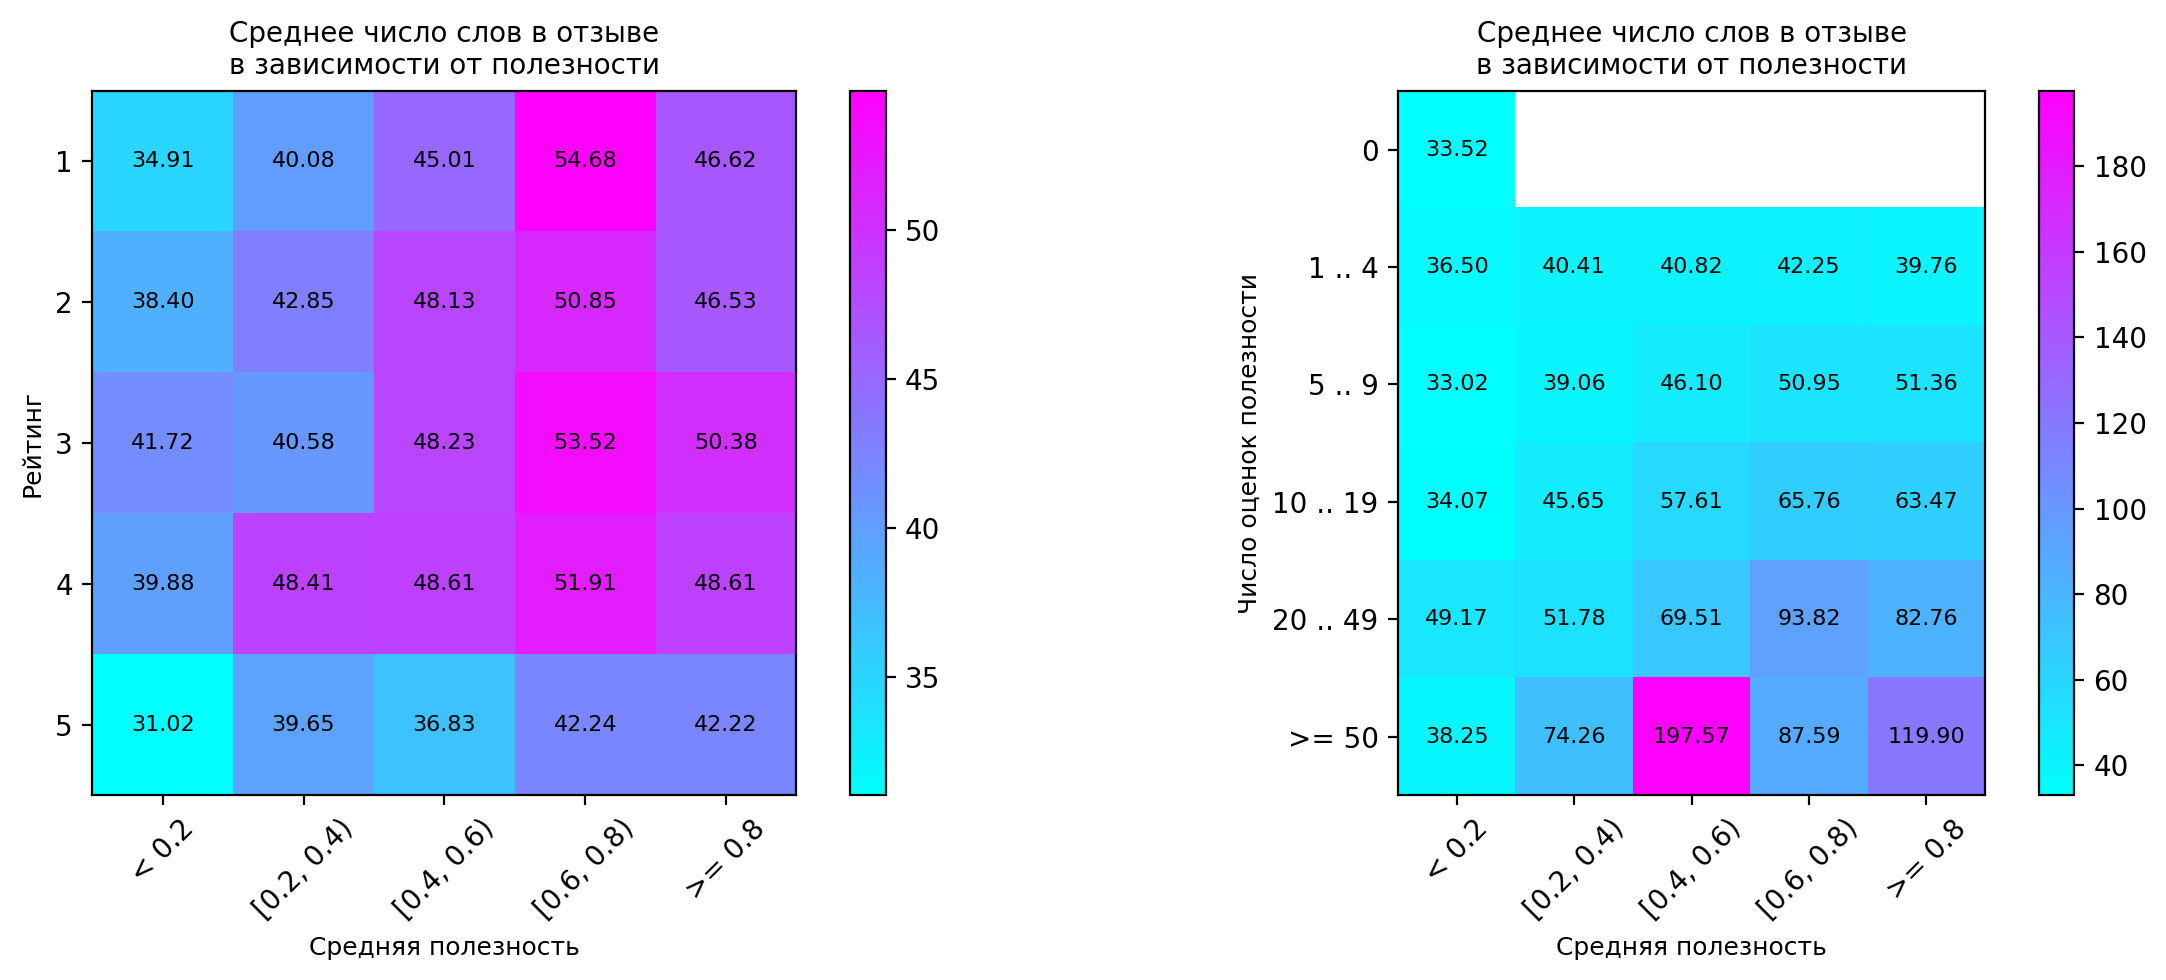

In [26]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 5), dpi=200)

# ----------------

plt.sca(axs[0])

intervals = pd.IntervalIndex.from_breaks([0.0, 0.2, 0.4, 0.6, 0.8, np.inf], closed="left")
labels = ("< 0.2", "[0.2, 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", ">= 0.8")

plot_data = raw_df.assign(HS_group=pd.cut(raw_df.HS, intervals_hs)).\
    groupby(["Score", "HS_group"]).agg({"nwords": "mean"}).values.reshape((5, len(intervals_hs)))

plt.imshow(plot_data, cmap="cool")

itr = np.nditer(plot_data, flags=["multi_index"])

for x in itr:
    idx = itr.multi_index
    plt.text(idx[1], idx[0], f"{x:.2f}" if not np.isnan(x) else "", ha="center", va="center", fontsize=8)
    
_ = plt.title("Среднее число слов в отзыве\nв зависимости от полезности", fontsize=10)
_ = plt.xlabel("Средняя полезность", fontsize=9)
_ = plt.ylabel("Рейтинг", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals)), labels=labels, rotation=45)
_ = plt.yticks(np.arange(0, 5), labels=np.arange(1, 5 + 1))

plt.colorbar()

# ----------------

plt.sca(axs[1])

intervals_hd = pd.IntervalIndex.from_breaks([0, 1, 5, 10, 20, 50, np.inf], closed="left")
intervals_hs = pd.IntervalIndex.from_breaks([0.0, 0.2, 0.4, 0.6, 0.8, np.inf], closed="left")
labels_hd = ("0", "1 .. 4", "5 .. 9", "10 .. 19", "20 .. 49", ">= 50")
labels_hs = ("< 0.2", "[0.2, 0.4)", "[0.4, 0.6)", "[0.6, 0.8)", ">= 0.8")

plot_data = raw_df.assign(HD_group=pd.cut(raw_df.HD, intervals_hd), HS_group=pd.cut(raw_df.HS, intervals_hs)).\
    groupby(["HD_group", "HS_group"]).agg({"nwords": "mean"}).values.reshape((len(intervals_hd), len(intervals_hs)))

plt.imshow(plot_data, cmap="cool")

itr = np.nditer(plot_data, flags=["multi_index"])

for x in itr:
    idx = itr.multi_index
    plt.text(idx[1], idx[0], f"{x:.2f}" if not np.isnan(x) else "", ha="center", va="center", fontsize=8)
    
_ = plt.title("Среднее число слов в отзыве\nв зависимости от полезности", fontsize=10)
_ = plt.xlabel("Средняя полезность", fontsize=9)
_ = plt.ylabel("Число оценок полезности", fontsize=9)
    
_ = plt.xticks(np.arange(0, len(intervals_hs)), labels=labels_hs, rotation=45)
_ = plt.yticks(np.arange(0, len(intervals_hd)), labels=labels_hd)

plt.colorbar()

# ----------------

plt.tight_layout()

Зависимость полезности отзыва от числа слов схожа с зависимостью от числа предложений (что ожидаемо, вполне вероятно, что существует сильная корреляция между длиной текста в словах и в предложениях). При этом взаимосвязь рейтинга и полезности отзыва весьма сложная. Можно заметить, что полезные отзывы в среднем длиннее, при этом положительные отзывы короче нейтральных и отрицательных.

### Характерные слова для эмоционально окрашенных отзывов

Обратимся теперь к содержанию отзывов - к текстам. Взвесим все слова с помощью `TfIdf`, после чего обучим простую модель (логистическую регрессию) отличать различные категории только по содержанию, после чего изобразим самые значимые слова в каждой категории.

In [27]:
TV = TfidfVectorizer(tokenizer=lambda x: x, lowercase=False, max_features=int(1e5)).fit(raw_df.words)
X = TV.transform(raw_df.words)
print(len(TV.get_feature_names()))

100000


#### Негативные отзывы

Обучим логистическую регрессию для определения негативных отзывов (рейтинг $1$).

In [28]:
target = (raw_df.Score == 1).values.astype(np.int)
Xtr, Xval, Ytr, Yval = train_test_split(X, target, test_size=0.2, random_state=127, shuffle=True)

lm = LogisticRegression(solver="liblinear", max_iter=int(1e4)).fit(Xtr, Ytr)
print(f"ROC-AUC: {roc_auc_score(Yval, lm.predict_proba(Xval)[:, 1]):.4f}")

ROC-AUC: 0.9516


Теперь изобразим наиболее характерные слова для обеих категорий (чем больше шрифт - тем важнее слово).

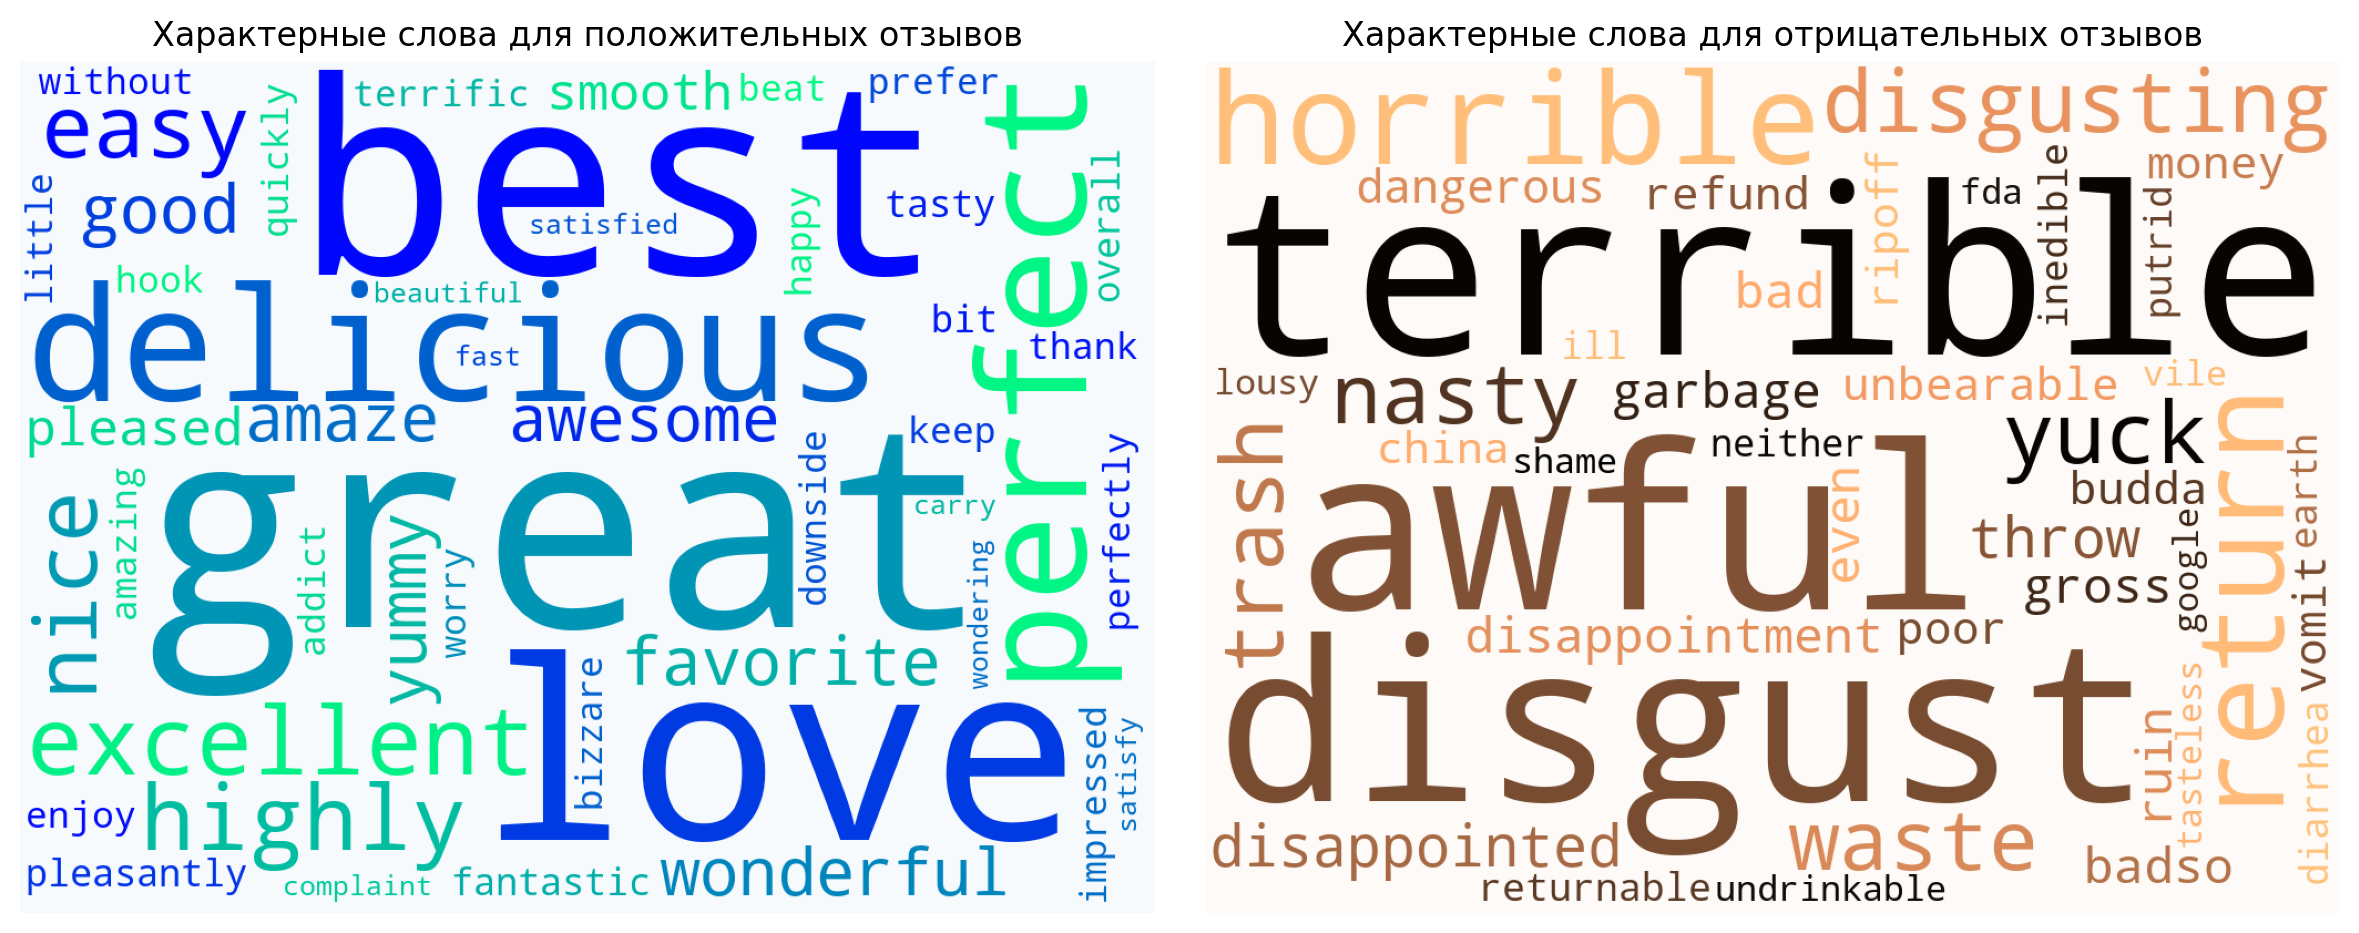

In [29]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), dpi=200)

nwords = 100
words = TV.get_feature_names()
idxs = np.argsort(lm.coef_).ravel()
words_negative = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[:nwords]}
words_positive = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[-nwords:]}

# ----------------

plt.sca(axs[0])

wc = WordCloud(
    width=1024, height=768, background_color="#f7fafd", margin=8, colormap="winter", 
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_negative)
plt.imshow(wc)

_ = plt.title("Характерные слова для положительных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.sca(axs[1])

wc = WordCloud(
    width=1024, height=768, background_color="#fdfaf7", margin=8, colormap="copper",
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_positive)
plt.imshow(wc)
    
_ = plt.title("Характерные слова для отрицательных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.tight_layout()

Достаточно ожидаемый результат. Наиболее характерные для негативных отзывов слова ("awful", "disgust", "terrible") связаны с разочарованием и плохими ощущениями, а топ слов для остальных (среди которых сильно преобладают положительные) ассоциируется с положительными ощущениями. 

#### Нейтральные отзывы

Теперь обучим логистическую регрессию для отличать нейтральные отзывы (рейтинг $3$).

In [30]:
target = (raw_df.Score == 3).values.astype(np.int)
Xtr, Xval, Ytr, Yval = train_test_split(X, target, test_size=0.2, random_state=127, shuffle=True)

lm = LogisticRegression(solver="liblinear", max_iter=int(1e4)).fit(Xtr, Ytr)
print(f"ROC-AUC: {roc_auc_score(Yval, lm.predict_proba(Xval)[:, 1]):.4f}")

ROC-AUC: 0.8577


Модель весьма неплохо определяет нейтральные отзывы. Изобразим наиболее характерные слова для обеих категорий (чем больше шрифт - тем важнее слово).

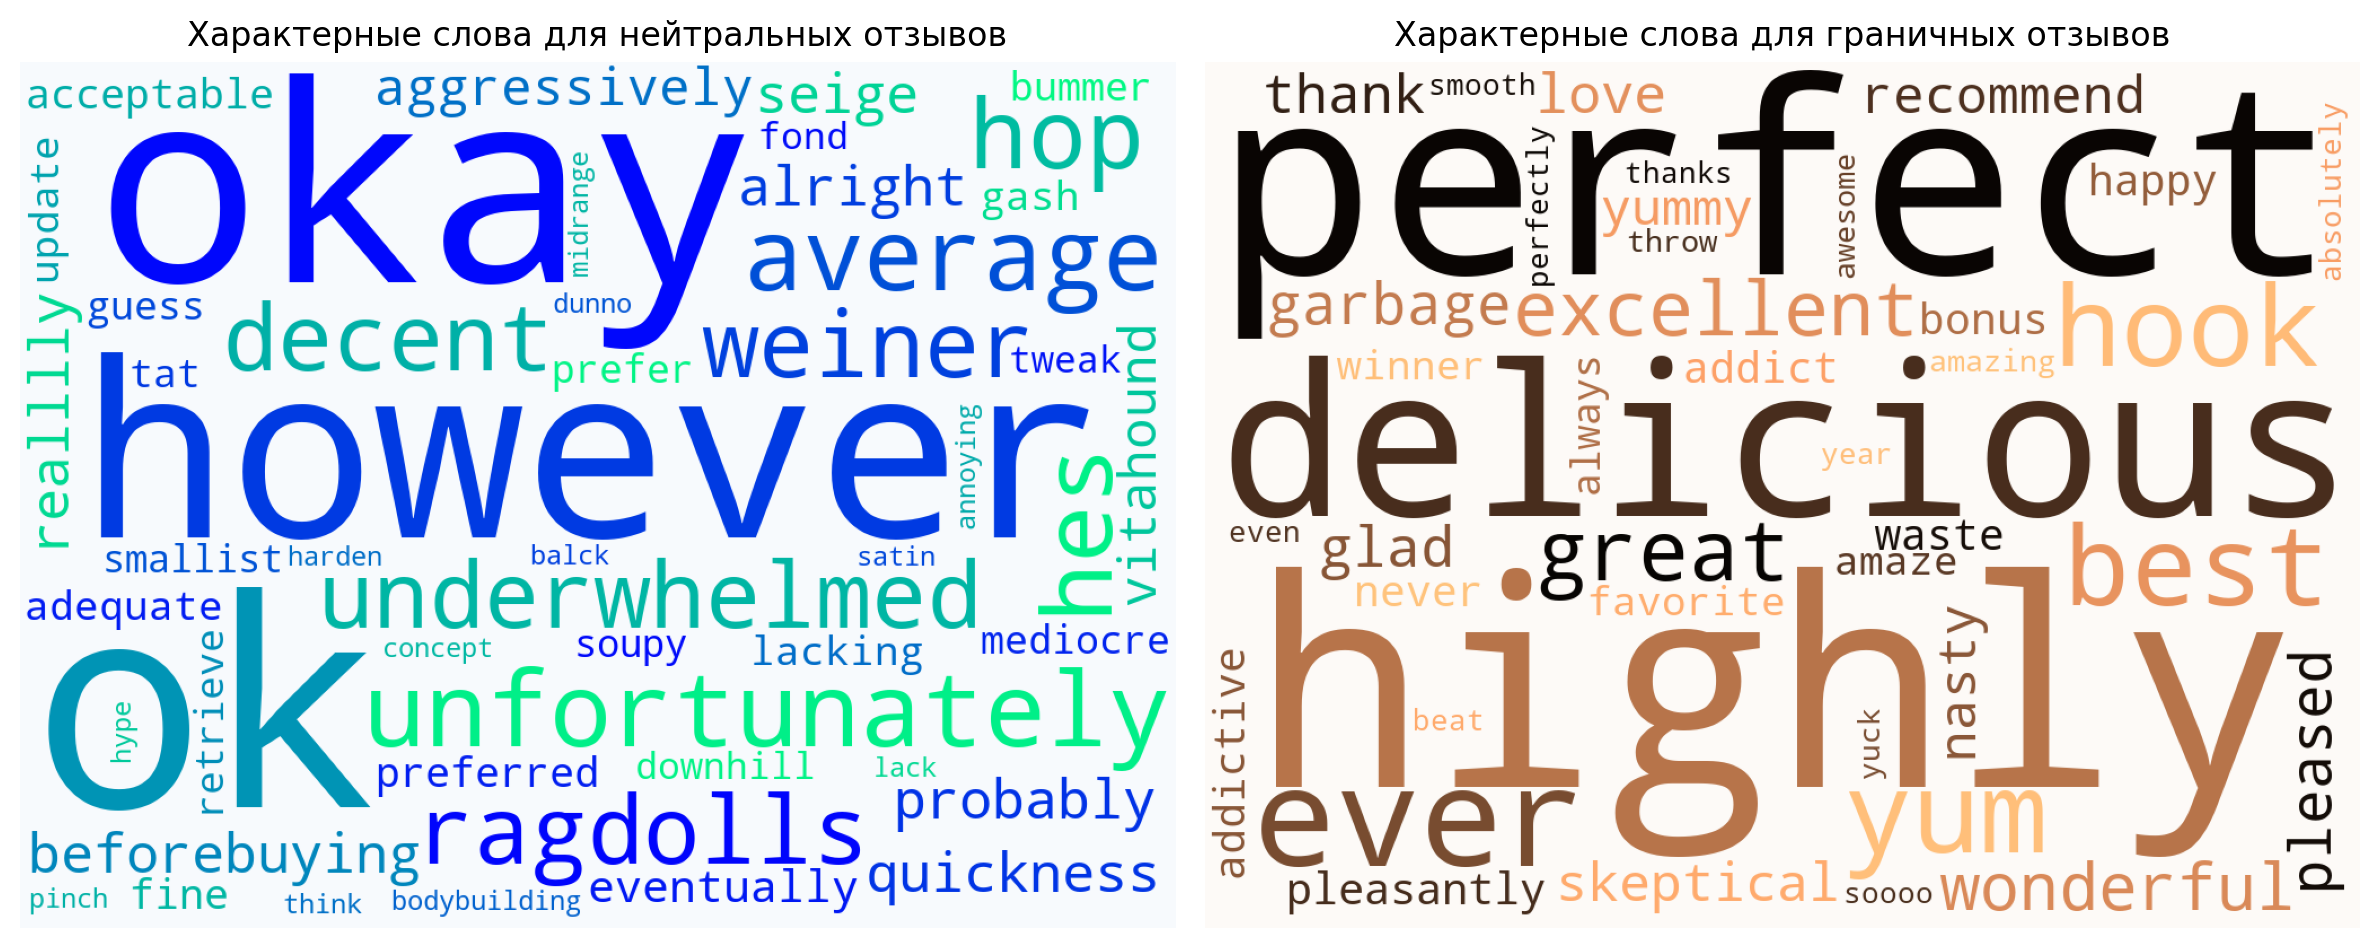

In [31]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), dpi=200)

nwords = 100
words = TV.get_feature_names()
idxs = np.argsort(lm.coef_).ravel()
words_negative = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[:nwords]}
words_positive = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[-nwords:]}

# ----------------

plt.sca(axs[0])

wc = WordCloud(
    width=1024, height=768, background_color="#f7fafd", margin=8, colormap="winter", 
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_positive)
plt.imshow(wc)

_ = plt.title("Характерные слова для нейтральных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.sca(axs[1])

wc = WordCloud(
    width=1024, height=768, background_color="#fdfaf7", margin=8, colormap="copper",
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_negative)
plt.imshow(wc)
    
_ = plt.title("Характерные слова для граничных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.tight_layout()

Видим, что среди нейтральных отзывов преобладают слова типа "okay", "average", "decent", "alright", обозначающие объекты среднего качества. Много также слов "unfortunately", "however" - скорее всего, они употребляются как "Продукт хорош тем-то и тем-то, но к сожалению, то-то и то-то не даёт мне поставить ему высокую оценку".

Граничные (т.е. либо негативные, либо позитивные) отзывы доминируются сильно положительными (вспомним распределение рейтинга), поэтому характерные для них слова в основном хвалебные (хотя есть, например, "garbage").

#### Полезные отзывы

Посмотрим теперь, отличаются ли семантически полезные и бесполезные отзывы (будем считать полезными те, у которых хотя бы $10$ оценок и которые полезны хотя бы на $75\%$).

In [32]:
target = ((raw_df.HD >= 10) & (raw_df.HS >= 0.75)).values.astype(np.int)
Xtr, Xval, Ytr, Yval = train_test_split(X, target, test_size=0.2, random_state=127, shuffle=True)

lm = LogisticRegression(solver="liblinear", max_iter=int(1e4)).fit(Xtr, Ytr)
print(f"ROC-AUC: {roc_auc_score(Yval, lm.predict_proba(Xval)[:, 1]):.4f}")

ROC-AUC: 0.8160


Опять же, мы весьма неплохо можем отличить полезные отзывы от бесполезных. Посмотрим на характерные слова.

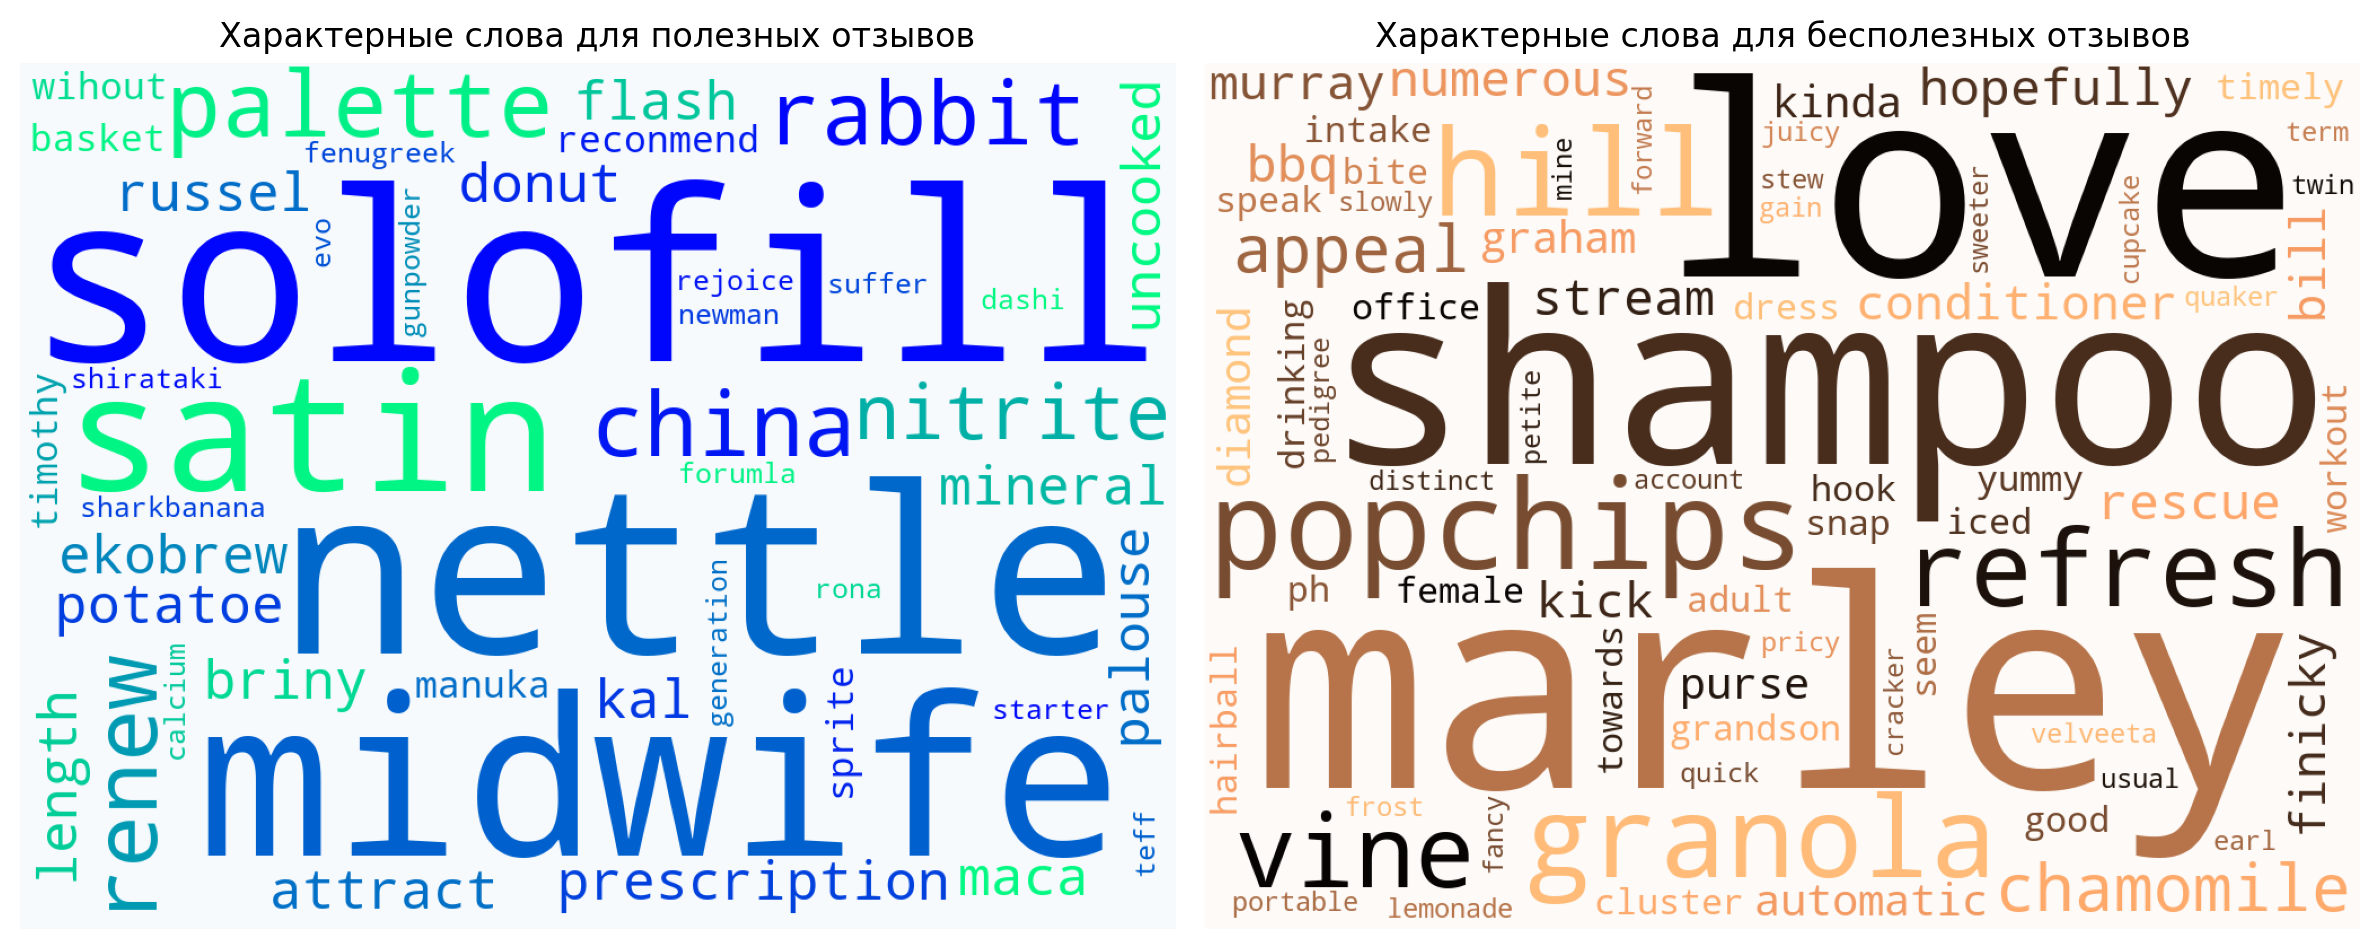

In [33]:
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(12, 6), dpi=200)

nwords = 100
words = TV.get_feature_names()
idxs = np.argsort(lm.coef_).ravel()
words_negative = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[:nwords]}
words_positive = {words[ix]: abs(lm.coef_[0, ix]) for ix in idxs[-nwords:]}

# ----------------

plt.sca(axs[0])

wc = WordCloud(
    width=1024, height=768, background_color="#f7fafd", margin=8, colormap="winter", 
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_positive)
plt.imshow(wc)

_ = plt.title("Характерные слова для полезных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.sca(axs[1])

wc = WordCloud(
    width=1024, height=768, background_color="#fdfaf7", margin=8, colormap="copper",
    min_font_size=24, max_font_size=256, max_words=nwords,
    random_state=127
).generate_from_frequencies(words_negative)
plt.imshow(wc)
    
_ = plt.title("Характерные слова для бесполезных отзывов", fontsize=12)
plt.gca().axis("off")

# ----------------

plt.tight_layout()

Хмм... несмотря на очень неплохое качество модели я не могу определить, чем существенно отличаются группы характерных слов. Почему-то справа (в бесполезных отзывах) много косметики для волос :).

## Что можно было бы сделать ещё

- Лучше предобработать слова. Даже среди характерных можно заметить опечатки и пропущенные или лишние пробелы;
- Провести дополнительный анализ пользователей по их никам;
- Проанализировать заголовки отзывов;